# Load packages

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [3]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker

In [5]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [6]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [7]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [8]:
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Specify parameters

In [9]:
file_name = "../OD_pair/CERNET-OD_pair.csv"  # the input filename
history = 10  # input historical time steps
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio
max_evals = 100  # maximal trials for hyper parameter tuning

model_name = 'MLP'
y_true_fn = '%s_true_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)
y_pred_fn = '%s_pred_TM-minmax-%d-%d.pkl' % (model_name, history, horizon)

RMSE_fn = model_name + '_TM-minmax_RMSE-%d-%d-step-%d.pdf'
MAE_fn = model_name + '_TM-minmax_MAE-%d-%d-step-%d.pdf'

In [10]:
y_true_fn

'MLP_true_TM-minmax-10-1.pkl'

In [11]:
y_pred_fn

'MLP_pred_TM-minmax-10-1.pkl'

# Load data

In [12]:
df = pd.read_csv(file_name)

In [13]:
df.head()

time        OD_1-1       OD_1-2        OD_1-3        OD_1-4  \
0  2013-02-19-22-10  3.897921e+06  3660.257162  2.038509e+06  54492.199769   
1  2013-02-19-22-15  3.714310e+06  4102.475155  2.010658e+06  44398.935617   
2  2013-02-19-22-20  3.824844e+06  3475.827556  2.022040e+06  39446.603085   
3  2013-02-19-22-25  3.967014e+06  3616.911661  2.005270e+06  42316.578675   
4  2013-02-19-22-30  3.708735e+06  3464.036062  2.017856e+06  44239.873981   

          OD_1-5         OD_1-6         OD_1-7         OD_1-8        OD_1-9  \
0  234230.295946   84819.101740  326551.951138   70567.750666  12520.192382   
1  200445.246659  118932.827733  345145.938997   73246.388000  13969.378085   
2  191539.466968  143379.788071  380456.462916   88085.648186  13683.572258   
3  171440.464195  139779.197759  399477.041689  100997.455279  13928.180880   
4  150425.682249  134512.997369  388659.765735   95906.154986  12303.793875   

   ...  OD_14-5  OD_14-6   OD_14-7      OD_14-8  OD_14-9      OD_14-10  \
0  ...      0.0      0.0  0.000000  1381.832533      0.0  10897.764534   
1  ...      0.0      0.0  0.000000  1123.647467      0.0  10333.189333   
2  ...      0.0      0.0  0.000000  1430.037600      0.0   9900.663200   
3  ...      0.0      0.0  0.000000  1954.184000      0.0  10663.956267   
4  ...      0.0      0.0  0.083324  3102.597333      0.0   7687.432800   

   OD_14-11      OD_14-12  OD_14-13  OD_14-14  
0       0.0  36048.613333       0.0       0.0  
1       0.0  32883.840000       0.0       0.0  
2       0.0  28923.253333       0.0       0.0  
3       0.0  34839.440000       0.0       0.0  
4       0.0  35943.493333       0.0       0.0  

[5 rows x 197 columns]

Parse the time column:

In [14]:
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d-%H-%M')  # Parse the time

Remove the outliers:

In [15]:
data_columns = list(df.columns.values)
data_columns.remove('time')
data = df[data_columns].values
# data = np.clip(data, 0.0, np.percentile(data.flatten(), 99))  # we use 99% as the threshold
# df[data_columns] = data

# Split the data

Split the data based on the test_ratio parameter. Aggreate the data and plot the training/testing split first:

In [16]:
aggregated_time_series = np.sum(data, axis=1)
df_ts = pd.DataFrame()
df_ts['date'] = df['time']
df_ts['data'] = aggregated_time_series / 1000  # Plot in Mbps

# add a datetimeindex
dates = pd.DatetimeIndex(df_ts['date'])
df_ts = df_ts.set_index(dates).asfreq('5T') 

In [17]:
test_length = int(df.shape[0] * test_ratio)
train_length = df.shape[0] - test_length

In [18]:
df_ts.index[train_length:][0]

Timestamp('2013-03-19 16:50:00', freq='5T')

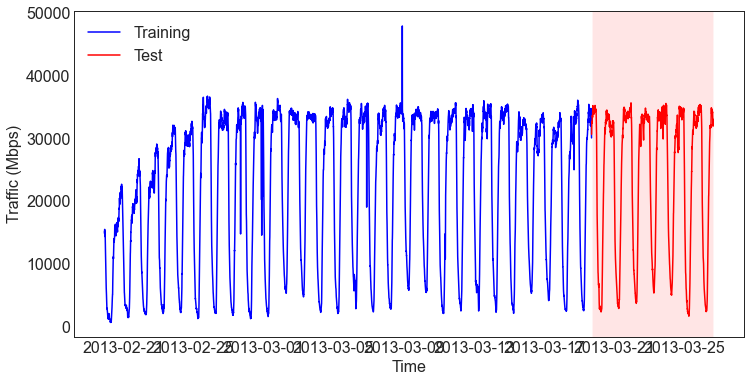

In [19]:
plt.figure(figsize=[12, 6])
plt.plot(df_ts.index[:train_length], df_ts['data'][:train_length], label='Training', color='blue')
plt.plot(df_ts.index[train_length:], df_ts['data'][train_length:], label='Test', color='red')
plt.axvspan(df_ts.index[train_length:][0], df_ts.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('training_test_split.pdf', bbox_inches = 'tight', pad_inches = 0.1)

Plot the training / testing split:

# Normalize the data

Calculate the min and max data based on the training data set:

In [20]:
max_list = np.max(data[:train_length], axis=0)

In [21]:
min_list = np.min(data[:train_length], axis=0)

Normalize the data and fill the data:

In [22]:
data = (data - min_list) / (max_list - min_list)
data[np.isnan(data)] = 0  # fill the abnormal data with 0
data[np.isinf(data)] = 0

In [23]:
print(np.max(data[:train_length].flatten()))

1.0


In [24]:
print(np.min(data[:train_length].flatten()))

0.0


The training data is in a range of [0, 1] but the test data may be out of this range:

In [25]:
print(np.max(data.flatten()))

2.0845760812827483


In [26]:
print(np.min(data.flatten()))

-0.004873735825012876


# Build the supervised prediction problem

The input data is in the following format:
* x_data as input features: [data size, input historical steps, input channels]. Here the input channel number is the OD pair number.
* y_data as output targets: [data size, output prediction steps, output channels].

In [27]:
x_data = []
y_data = []

In [28]:
length = data.shape[0]
print(length)

9999


In [29]:
for i in range(length - history - horizon + 1):
    x = data[i:i+history, :]  # input historical time steps
    y = data[i+history:i+history+horizon:, :]  # output predicted time steps
    x_data.append(x)
    y_data.append(y)

In [30]:
x_data = np.array(x_data)
y_data = np.array(y_data)

In [31]:
x_data.shape

(9989, 10, 196)

In [32]:
y_data.shape

(9989, 1, 196)

Reshape x_data:

In [33]:
x_data = np.swapaxes(x_data, 1, 2)

Reshape y_data:

In [34]:
y_data = y_data.reshape(y_data.shape[0], -1)
y_data.shape

(9989, 196)

The last test_length samples are fixed as test data. The training data size may vary with the input historical time steps. The test data size may vary with the prediction horizon.

In [35]:
test_length = test_length - horizon + 1

In [36]:
train_valid_length = x_data.shape[0] - test_length

In [37]:
train_valid_length

7990

We further split a valid data set for hyper parameter tuning:

In [38]:
train_length = int(train_valid_length * 0.8)
valid_length = train_valid_length - train_length

In [39]:
train_length

6392

In [40]:
valid_length

1598

In [41]:
X_train = x_data[:train_length]
y_train = y_data[:train_length]
X_valid = x_data[train_length:train_valid_length]
y_valid = y_data[train_length:train_valid_length]
X_test = x_data[train_valid_length:]
y_test = y_data[train_valid_length:]

In [42]:
X_train.shape

(6392, 196, 10)

In [43]:
y_train.shape

(6392, 196)

In [44]:
X_valid.shape

(1598, 196, 10)

In [45]:
y_valid.shape

(1598, 196)

In [46]:
X_test.shape

(1999, 196, 10)

In [47]:
y_test.shape

(1999, 196)

# Build TSAI Datasets

Now we are ready to use the tsai package with its dataset definition:

In [48]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [49]:
X.shape

(7990, 196, 10)

In [50]:
y.shape

(7990, 196)

In [51]:
splits

((#6392) [0,1,2,3,4,5,6,7,8,9...],
 (#1598) [6392,6393,6394,6395,6396,6397,6398,6399,6400,6401...])

Make sure this is a regression task, instead of a classification task (using TSRegression as follows):

In [52]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#7990) [(TSTensor(vars:196, len:10), tensor([3.0473e-01, 4.0979e-03, 8.5294e-01, 3.2505e-01, 4.2390e-01, 1.7035e-01,
        2.3749e-01, 9.5876e-02, 6.0455e-02, 2.5291e-01, 2.3859e-01, 3.9024e-01,
        3.8565e-01, 5.5069e-01, 3.1508e-03, 0.0000e+00, 3.8347e-04, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.1409e-03, 0.0000e+00, 3.2674e-05,
        0.0000e+00, 1.0261e-03, 0.0000e+00, 0.0000e+00, 5.8814e-01, 3.1805e-05,
        3.6734e-02, 2.0680e-02, 1.1481e-01, 1.7415e-01, 1.7546e-01, 4.7027e-02,
        3.2714e-01, 3.2840e-01, 2.6392e-01, 2.5046e-01, 2.2083e-01, 8.3459e-01,
        8.6948e-02, 0.0000e+00, 3.6272e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 5.3882e-04, 0.0000e+00, 6.2002e-02, 0.0000e+00, 4.5756e-02,
        0.0000e+00, 0.0000e+00, 4.2969e-01, 0.0000e+00, 1.5752e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 9.6673e-02, 0.0000e+00, 1.0326e-01,
        0.0000e+00, 1.9820e-01, 0.0000e+00, 0.0000e+00, 1.3957e-01, 1.2948e-05,
  

# Model Building and Hyperparameter Tuning

We use the hyperopt package to search for hyper parameters:

In [53]:
search_space = {
    'batch_size': hp.choice('bs', [16, 32, 64, 128]),
    "lr": hp.choice('lr', [0.1, 0.01, 0.001]),
    "epochs": hp.choice('epochs', [20, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    # "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    "optimizer": hp.choice('optimizer', [Adam]),
    # model parameters
    "layers": hp.choice('layers', [[100, 100, 100], [200, 200, 200], [500, 500, 500]]),
    "fc_dropout": hp.choice('fc_dropout', [0.1, 0.2, 0.5])
}

In [54]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x1f32446cc88>,
 'lr': <hyperopt.pyll.base.Apply at 0x1f32446cd88>,
 'epochs': <hyperopt.pyll.base.Apply at 0x1f32445a608>,
 'patience': <hyperopt.pyll.base.Apply at 0x1f32445a888>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x1f32445a7c8>,
 'layers': <hyperopt.pyll.base.Apply at 0x1f32445cc08>,
 'fc_dropout': <hyperopt.pyll.base.Apply at 0x1f32445cb48>}

In [55]:
# clear memory 
gc.collect()

0

In [56]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:", params)
        batch_size = params["batch_size"]
    
        # Create data loader
        tfms  = [None, [TSRegression()]]
        dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = MLP
        k = {
            'layers': params['layers'],
            'fc_dropout': params['fc_dropout']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
        
        # Add a Sigmoid layer
        model = nn.Sequential(model, nn.Sigmoid())
    
        # Training the model
        learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
        print(elapsed)
    
        vals = learn.recorder.values[-1]
        print(vals)
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
  0%|                                                                          | 0/100 [00:02<?, ?trial/s, best loss=?]

No improvement since epoch 38: early stopping                                                                          
  0%|                                                                          | 0/100 [00:17<?, ?trial/s, best loss=?]

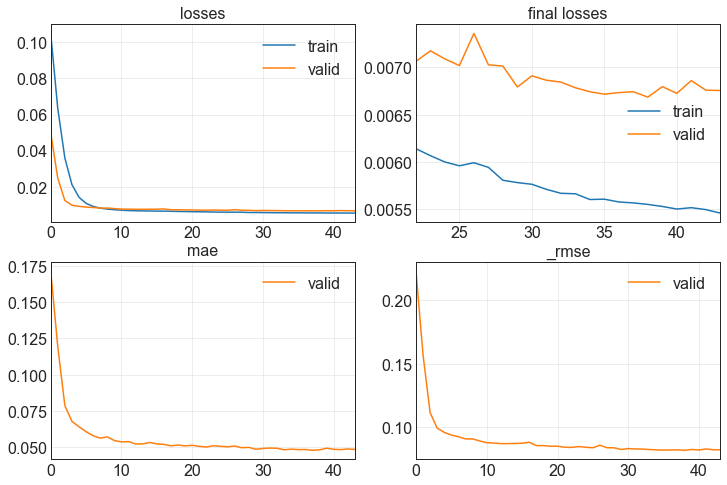

15.36104679107666                                                                                                      
[0.005461572203785181, 0.006756943184882402, 0.04855529963970184, 0.08220062404870987]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
  1%|▍                                             | 1/100 [00:18<29:29, 17.87s/trial, best loss: 0.006756943184882402]

No improvement since epoch 7: early stopping                                                                           
  1%|▍                                             | 1/100 [00:56<29:29, 17.87s/trial, best loss: 0.006756943184882402]

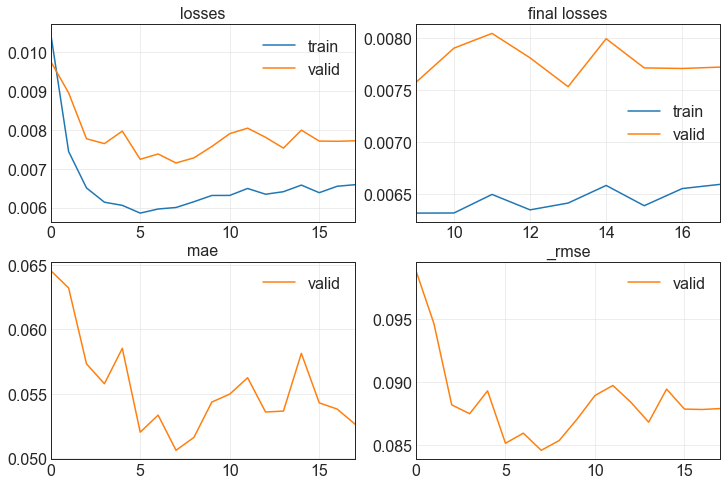

38.040250062942505                                                                                                     
[0.006591398268938065, 0.007722781039774418, 0.052633609622716904, 0.08787934482097626]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
  2%|▉                                             | 2/100 [00:58<39:35, 24.24s/trial, best loss: 0.006756943184882402]

No improvement since epoch 0: early stopping                                                                           
  2%|▉                                             | 2/100 [01:21<39:35, 24.24s/trial, best loss: 0.006756943184882402]

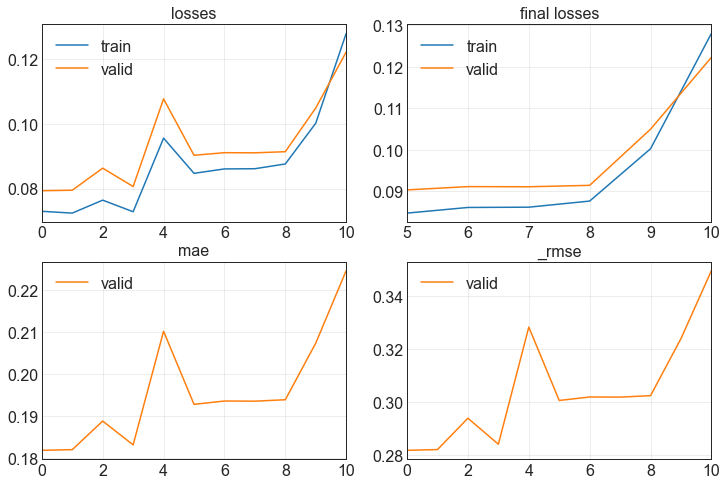

23.638765335083008                                                                                                     
[0.12804029881954193, 0.12227418273687363, 0.22473810613155365, 0.34967726469039917]                                   
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
  3%|█▍                                            | 3/100 [01:22<39:27, 24.41s/trial, best loss: 0.006756943184882402]

No improvement since epoch 38: early stopping                                                                          
  3%|█▍                                            | 3/100 [02:09<39:27, 24.41s/trial, best loss: 0.006756943184882402]

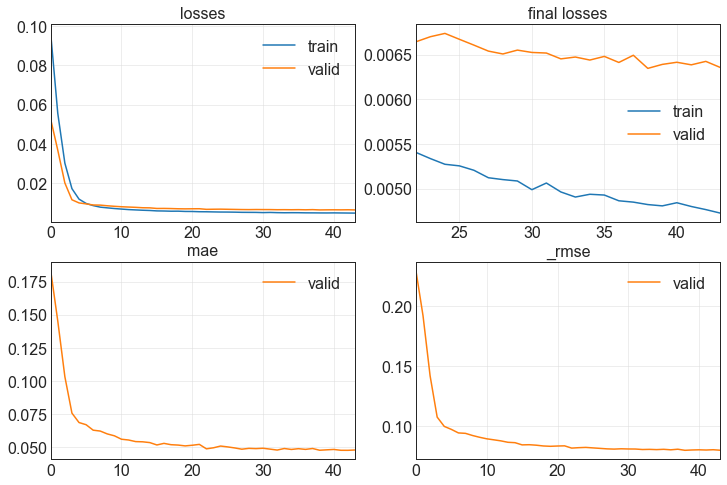

47.57259774208069                                                                                                      
[0.004726213403046131, 0.006357051432132721, 0.04768994450569153, 0.07973112910985947]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
  4%|█▊                                            | 4/100 [02:11<50:41, 31.68s/trial, best loss: 0.006357051432132721]

No improvement since epoch 10: early stopping                                                                          
  4%|█▊                                            | 4/100 [02:20<50:41, 31.68s/trial, best loss: 0.006357051432132721]

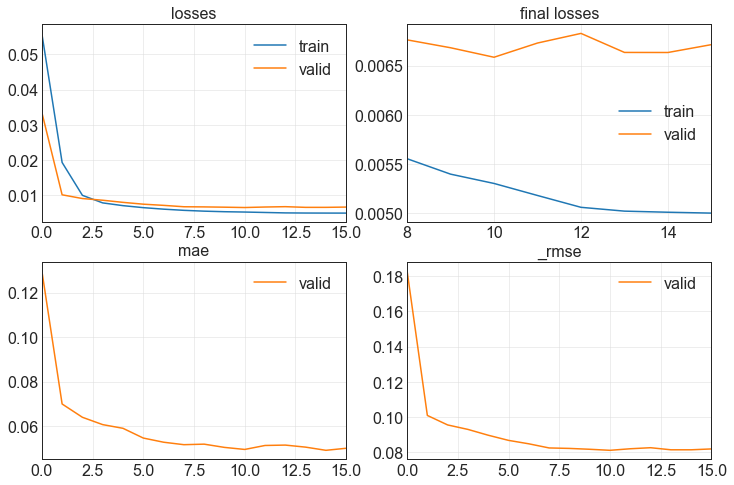

9.58687710762024                                                                                                       
[0.0050039044581353664, 0.006713558454066515, 0.05002231150865555, 0.081936314702034]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
  5%|██▎                                           | 5/100 [02:22<40:10, 25.38s/trial, best loss: 0.006357051432132721]

No improvement since epoch 67: early stopping                                                                          
  5%|██▎                                           | 5/100 [02:46<40:10, 25.38s/trial, best loss: 0.006357051432132721]

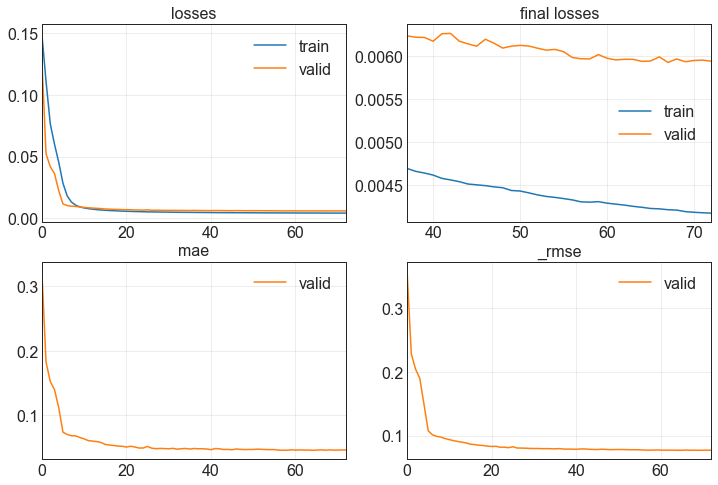

24.514365434646606                                                                                                     
[0.004172434099018574, 0.005937461741268635, 0.04627634957432747, 0.0770549327135086]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
  6%|██▊                                           | 6/100 [02:47<39:52, 25.45s/trial, best loss: 0.005937461741268635]

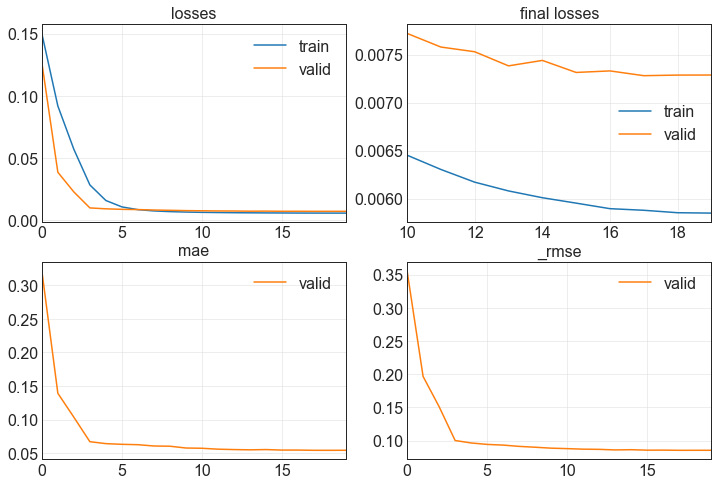

6.8461315631866455                                                                                                     
[0.005850126966834068, 0.007286525797098875, 0.054161738604307175, 0.08536115288734436]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (100, 100, 100), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
  7%|███▏                                          | 7/100 [02:55<31:18, 20.20s/trial, best loss: 0.005937461741268635]

No improvement since epoch 2: early stopping                                                                           
  7%|███▏                                          | 7/100 [03:12<31:18, 20.20s/trial, best loss: 0.005937461741268635]

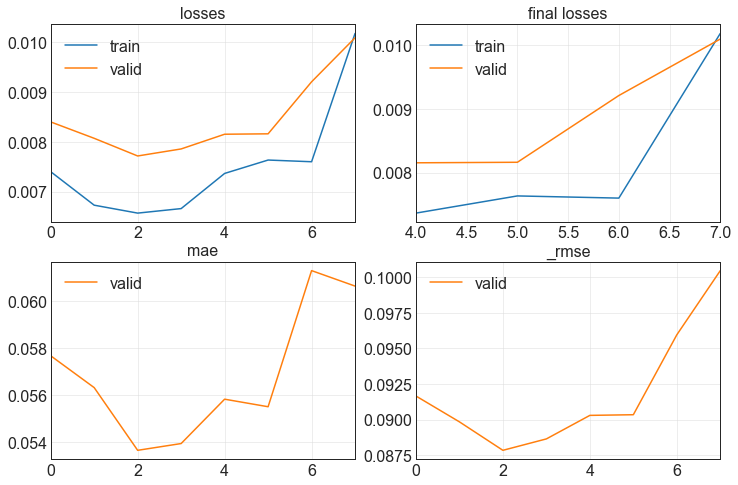

17.033543825149536                                                                                                     
[0.0101822130382061, 0.01009442564100027, 0.06062576174736023, 0.10047102719545364]                                    
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
  8%|███▋                                          | 8/100 [03:13<29:59, 19.56s/trial, best loss: 0.005937461741268635]

No improvement since epoch 16: early stopping                                                                          
  8%|███▋                                          | 8/100 [03:42<29:59, 19.56s/trial, best loss: 0.005937461741268635]

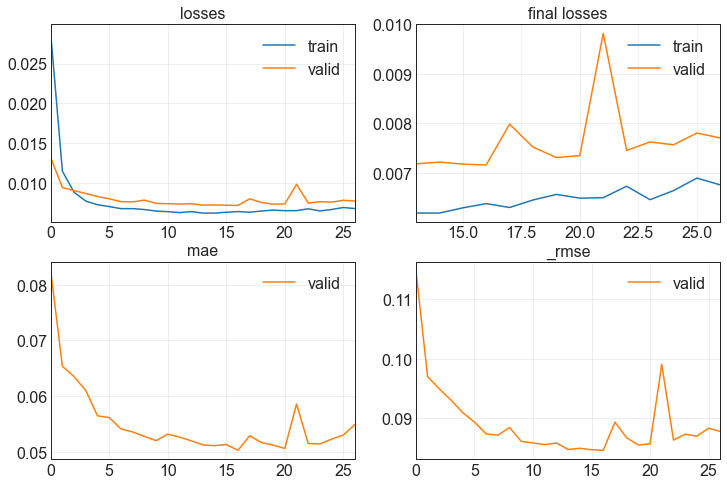

29.156609058380127                                                                                                     
[0.006759194657206535, 0.007707121782004833, 0.05495196953415871, 0.08779022097587585]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
  9%|████▏                                         | 9/100 [03:44<34:31, 22.76s/trial, best loss: 0.005937461741268635]

No improvement since epoch 27: early stopping                                                                          
  9%|████▏                                         | 9/100 [03:54<34:31, 22.76s/trial, best loss: 0.005937461741268635]

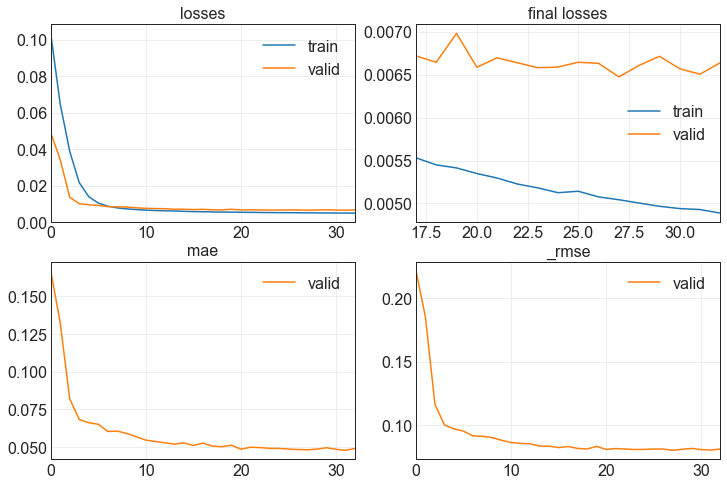

10.983198881149292                                                                                                     
[0.004888067487627268, 0.006639162544161081, 0.04902863875031471, 0.08148106187582016]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 10%|████▌                                        | 10/100 [03:56<29:19, 19.56s/trial, best loss: 0.005937461741268635]

No improvement since epoch 1: early stopping                                                                           
 10%|████▌                                        | 10/100 [04:00<29:19, 19.56s/trial, best loss: 0.005937461741268635]

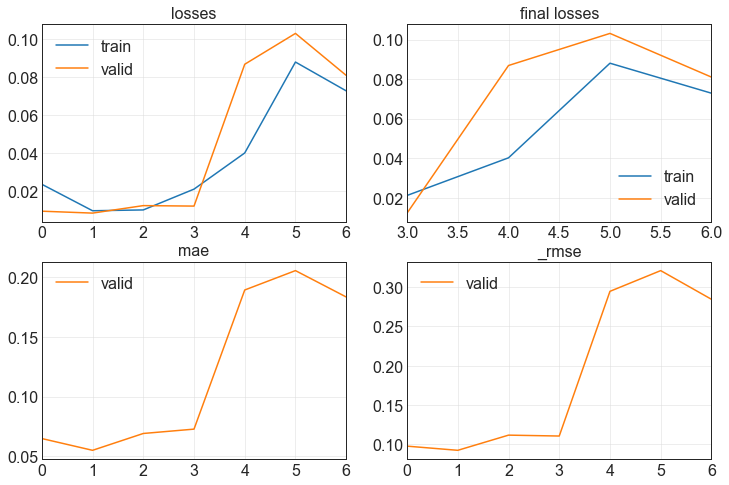

4.54016637802124                                                                                                       
[0.07286778837442398, 0.0810120701789856, 0.18347597122192383, 0.28462618589401245]                                    
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 11%|████▉                                        | 11/100 [04:01<22:48, 15.38s/trial, best loss: 0.005937461741268635]

No improvement since epoch 19: early stopping                                                                          
 11%|████▉                                        | 11/100 [04:11<22:48, 15.38s/trial, best loss: 0.005937461741268635]

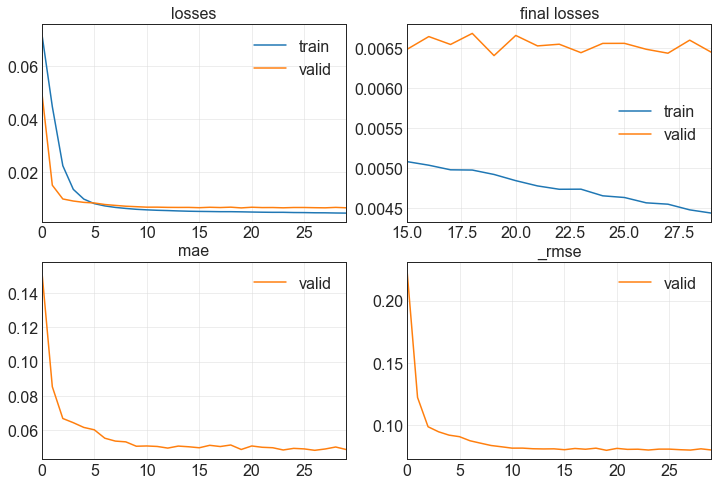

10.26238203048706                                                                                                      
[0.00444122264161706, 0.006449679844081402, 0.04860302060842514, 0.0803098976612091]                                   
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 12%|█████▍                                       | 12/100 [04:13<20:46, 14.17s/trial, best loss: 0.005937461741268635]

No improvement since epoch 1: early stopping                                                                           
 12%|█████▍                                       | 12/100 [04:15<20:46, 14.17s/trial, best loss: 0.005937461741268635]

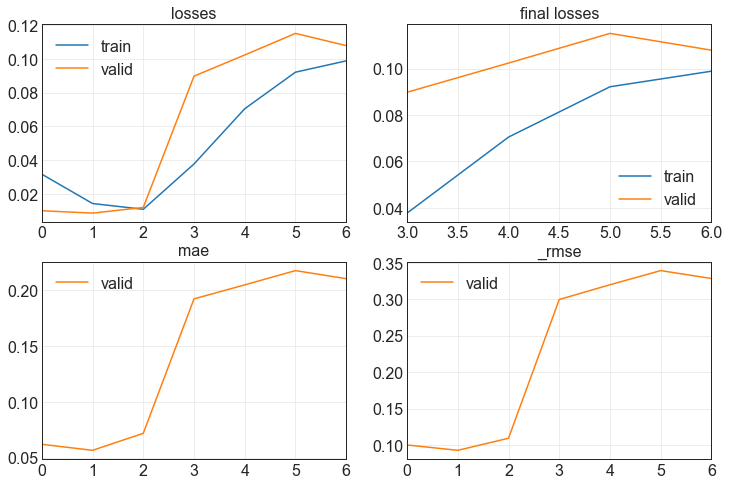

2.7295806407928467                                                                                                     
[0.0988488420844078, 0.10790292173624039, 0.21036683022975922, 0.32848578691482544]                                    
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 13%|█████▊                                       | 13/100 [04:16<16:02, 11.06s/trial, best loss: 0.005937461741268635]

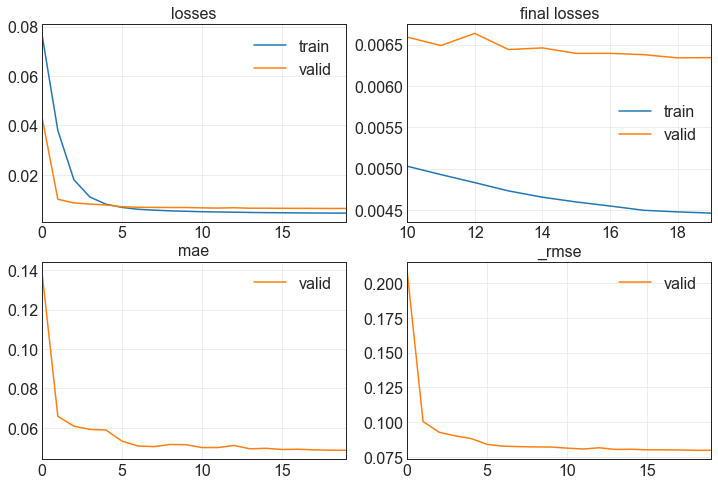

6.852091312408447                                                                                                      
[0.004460446070879698, 0.006342248059809208, 0.04856742545962334, 0.07963823527097702]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 14%|██████▎                                      | 14/100 [04:24<14:30, 10.12s/trial, best loss: 0.005937461741268635]

No improvement since epoch 13: early stopping                                                                          
 14%|██████▎                                      | 14/100 [04:45<14:30, 10.12s/trial, best loss: 0.005937461741268635]

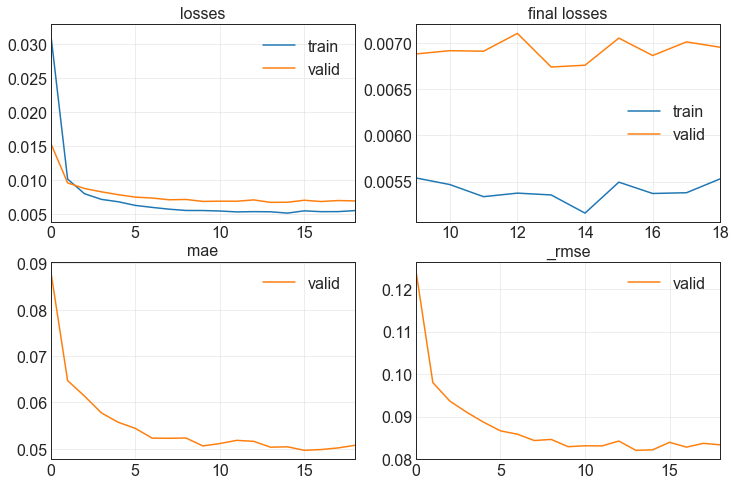

20.661197185516357                                                                                                     
[0.005530747584998608, 0.0069522736594080925, 0.05076677352190018, 0.08338028937578201]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 15%|██████▊                                      | 15/100 [04:46<19:17, 13.61s/trial, best loss: 0.005937461741268635]

No improvement since epoch 9: early stopping                                                                           
 15%|██████▊                                      | 15/100 [05:28<19:17, 13.61s/trial, best loss: 0.005937461741268635]

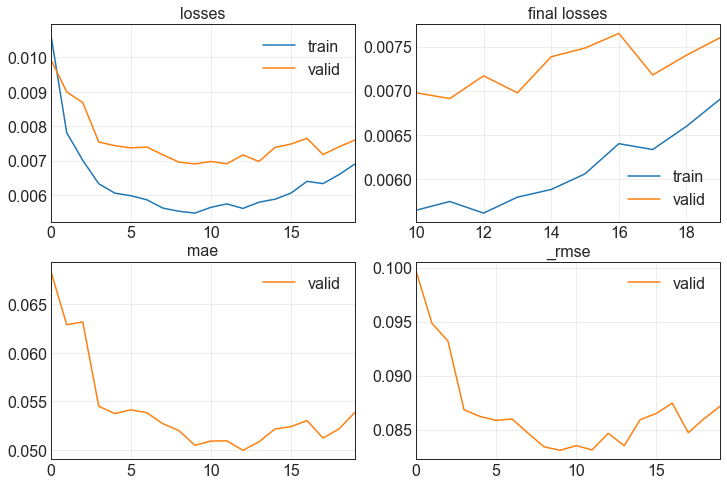

42.2404899597168                                                                                                       
[0.006904825568199158, 0.007601528894156218, 0.05388534069061279, 0.08718674629926682]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 16%|███████▏                                     | 16/100 [05:29<31:32, 22.53s/trial, best loss: 0.005937461741268635]

No improvement since epoch 1: early stopping                                                                           
 16%|███████▏                                     | 16/100 [05:55<31:32, 22.53s/trial, best loss: 0.005937461741268635]

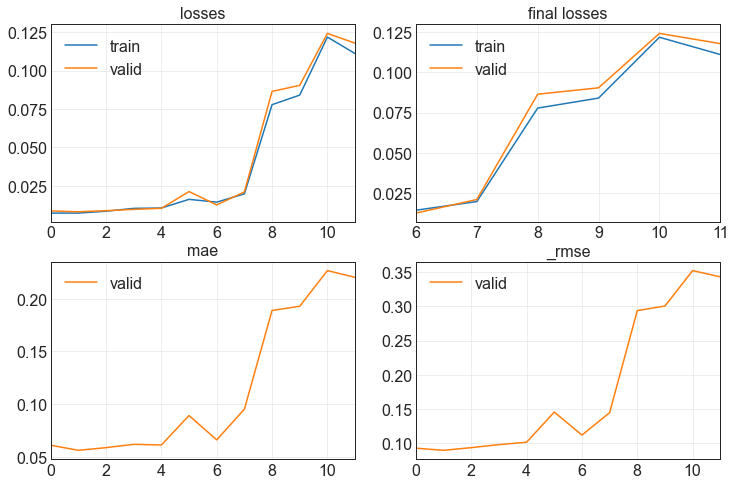

25.66951084136963                                                                                                      
[0.11107470095157623, 0.11784275621175766, 0.2203066051006317, 0.3432823419570923]                                     
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 17%|███████▋                                     | 17/100 [05:56<32:55, 23.80s/trial, best loss: 0.005937461741268635]

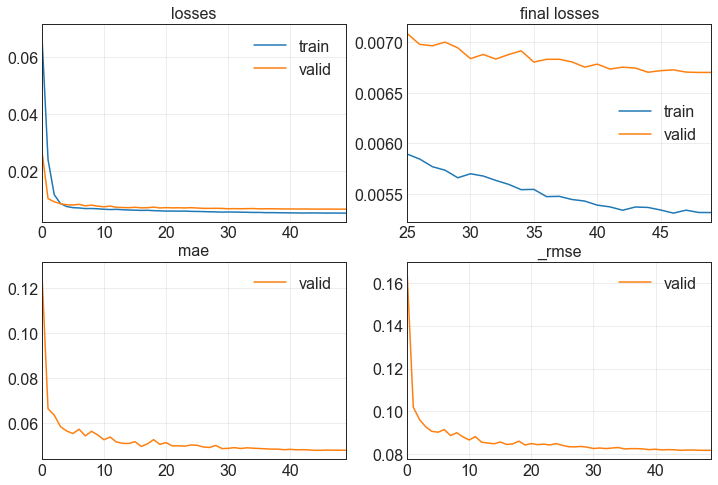

28.911165237426758                                                                                                     
[0.00531497597694397, 0.006702003534883261, 0.04797876998782158, 0.08186576515436172]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 18%|████████                                     | 18/100 [06:26<35:03, 25.65s/trial, best loss: 0.005937461741268635]

No improvement since epoch 1: early stopping                                                                           
 18%|████████                                     | 18/100 [06:39<35:03, 25.65s/trial, best loss: 0.005937461741268635]

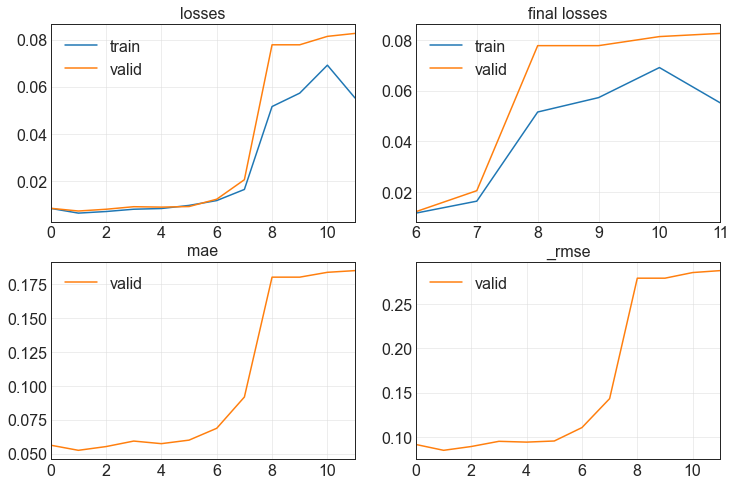

13.211248397827148                                                                                                     
[0.05517090857028961, 0.0826089009642601, 0.18507280945777893, 0.28741762042045593]                                    
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 19%|████████▌                                    | 19/100 [06:40<30:02, 22.25s/trial, best loss: 0.005937461741268635]

No improvement since epoch 3: early stopping                                                                           
 19%|████████▌                                    | 19/100 [06:56<30:02, 22.25s/trial, best loss: 0.005937461741268635]

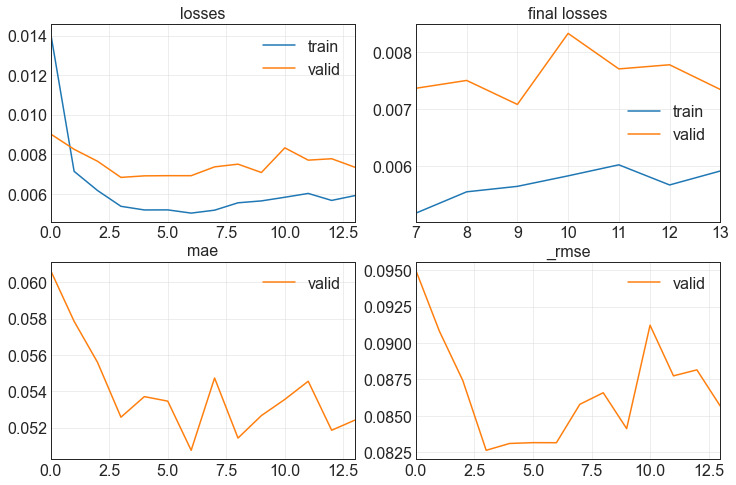

16.082348585128784                                                                                                     
[0.00590908620506525, 0.0073389834724366665, 0.052420977503061295, 0.08566787093877792]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 20%|█████████                                    | 20/100 [06:58<27:37, 20.72s/trial, best loss: 0.005937461741268635]

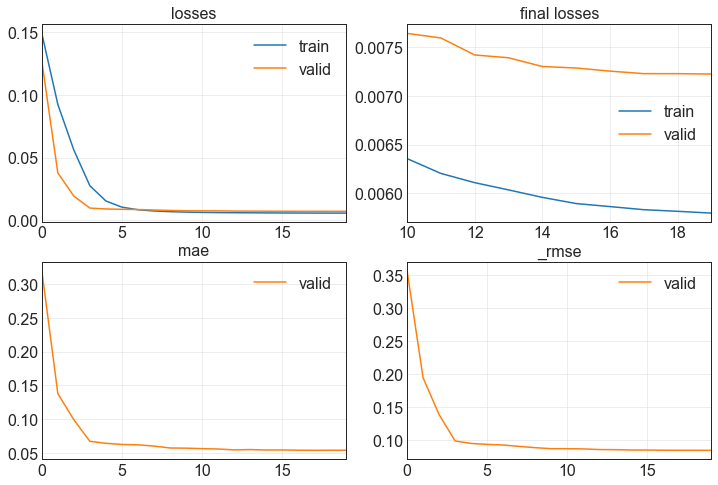

6.8631768226623535                                                                                                     
[0.005796351004391909, 0.007222955580800772, 0.05379009619355202, 0.08498798310756683]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 21%|█████████▍                                   | 21/100 [07:06<22:14, 16.89s/trial, best loss: 0.005937461741268635]

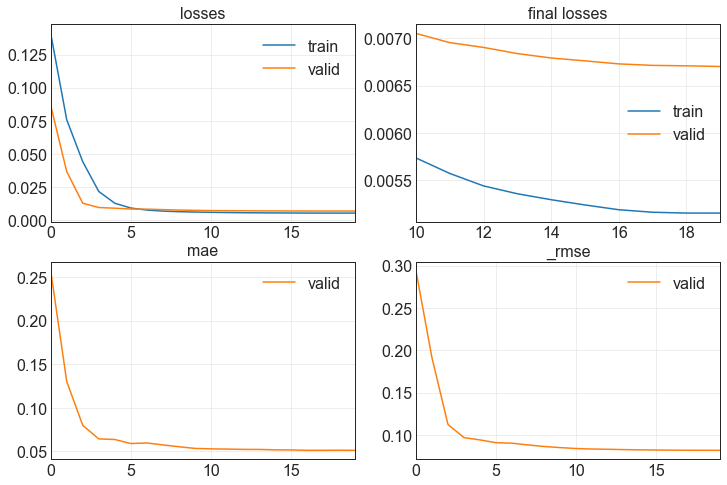

6.93121862411499                                                                                                       
[0.005151370540261269, 0.006703180260956287, 0.05123499408364296, 0.08187295496463776]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 22%|█████████▉                                   | 22/100 [07:14<18:29, 14.23s/trial, best loss: 0.005937461741268635]

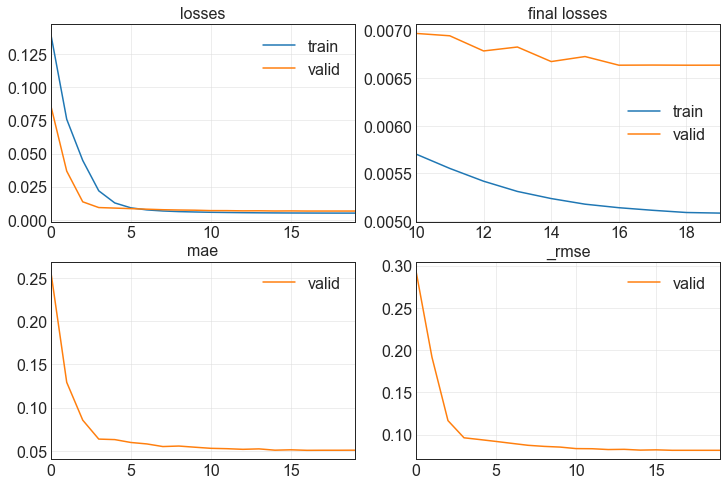

6.976202011108398                                                                                                      
[0.005082936026155949, 0.00663712015375495, 0.050905998796224594, 0.08146852254867554]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 23%|██████████▎                                  | 23/100 [07:22<15:53, 12.38s/trial, best loss: 0.005937461741268635]

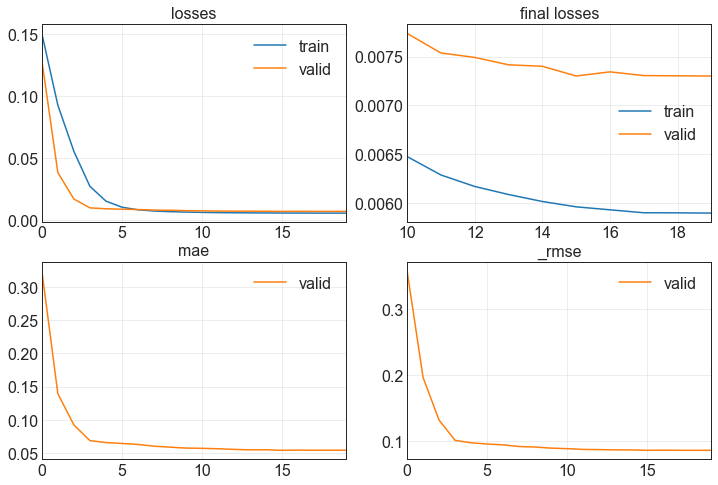

6.873218536376953                                                                                                      
[0.005898573435842991, 0.007300910539925098, 0.0539788156747818, 0.08544536679983139]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 24%|██████████▊                                  | 24/100 [07:30<13:59, 11.05s/trial, best loss: 0.005937461741268635]

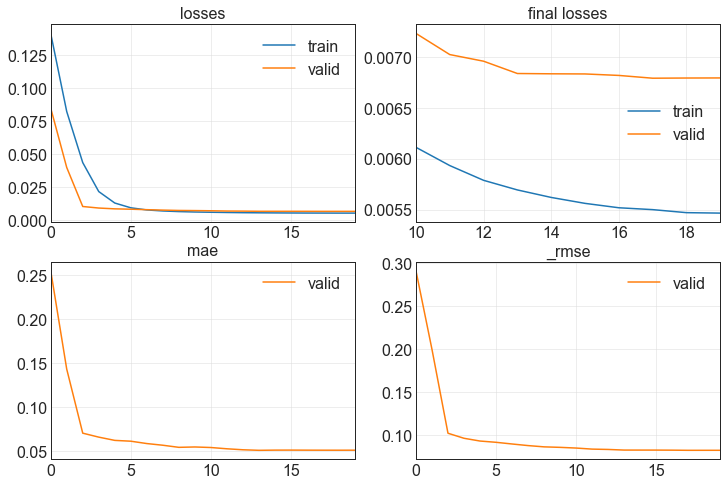

6.9471824169158936                                                                                                     
[0.005465550813823938, 0.006792819127440453, 0.050823573023080826, 0.08241856098175049]                                
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 20, 'fc_dropout': 0.5, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 25%|███████████▎                                 | 25/100 [07:38<12:40, 10.14s/trial, best loss: 0.005937461741268635]

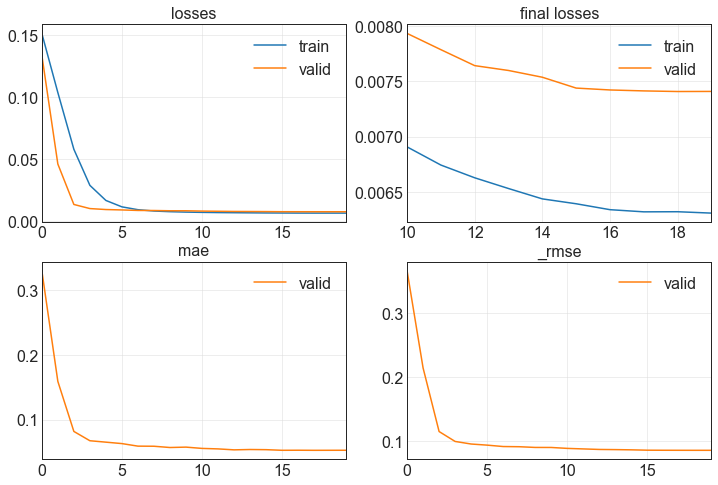

6.838175058364868                                                                                                      
[0.006307301577180624, 0.007409182842820883, 0.0527181513607502, 0.08607660979032516]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 26%|███████████▋                                 | 26/100 [07:46<11:40,  9.47s/trial, best loss: 0.005937461741268635]

No improvement since epoch 45: early stopping                                                                          
 26%|███████████▋                                 | 26/100 [08:16<11:40,  9.47s/trial, best loss: 0.005937461741268635]

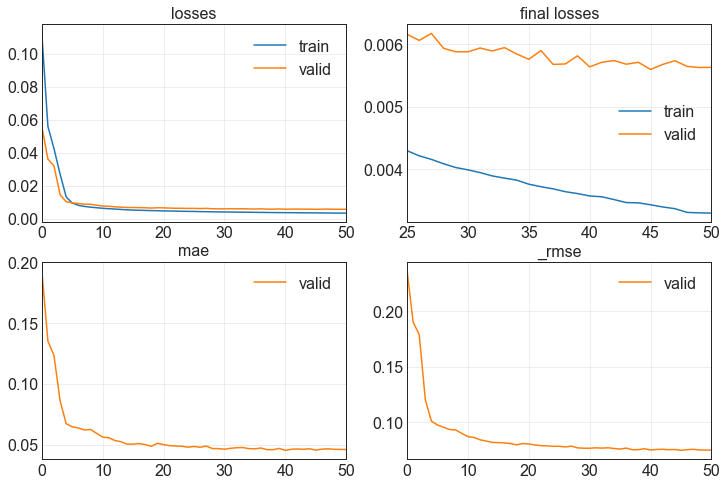

30.798715114593506                                                                                                     
[0.0032991250045597553, 0.0056266700848937035, 0.04590031877160072, 0.07501113414764404]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 27%|███████████▉                                | 27/100 [08:17<19:42, 16.20s/trial, best loss: 0.0056266700848937035]

No improvement since epoch 39: early stopping                                                                          
 27%|███████████▉                                | 27/100 [08:44<19:42, 16.20s/trial, best loss: 0.0056266700848937035]

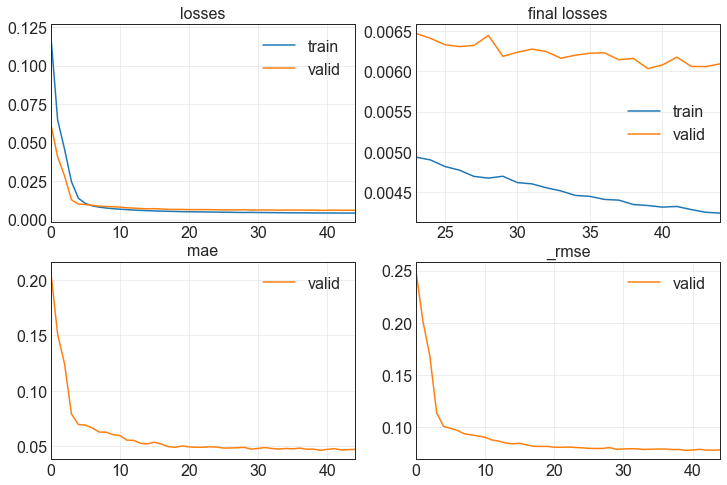

26.97495198249817                                                                                                      
[0.004237316083163023, 0.006093962118029594, 0.047026846557855606, 0.07806383073329926]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 28%|████████████▎                               | 28/100 [08:46<23:43, 19.77s/trial, best loss: 0.0056266700848937035]

No improvement since epoch 38: early stopping                                                                          
 28%|████████████▎                               | 28/100 [09:12<23:43, 19.77s/trial, best loss: 0.0056266700848937035]

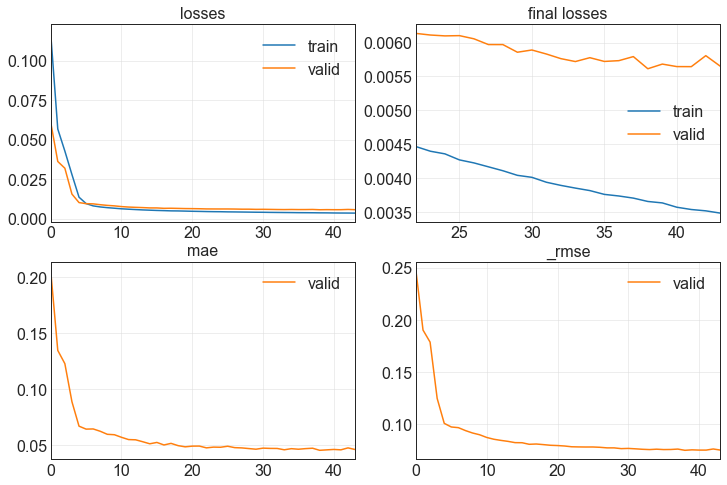

26.399614810943604                                                                                                     
[0.003484833287075162, 0.005650829989463091, 0.0459296815097332, 0.07517199963331223]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 29%|████████████▊                               | 29/100 [09:13<26:08, 22.10s/trial, best loss: 0.0056266700848937035]

No improvement since epoch 35: early stopping                                                                          
 29%|████████████▊                               | 29/100 [09:37<26:08, 22.10s/trial, best loss: 0.0056266700848937035]

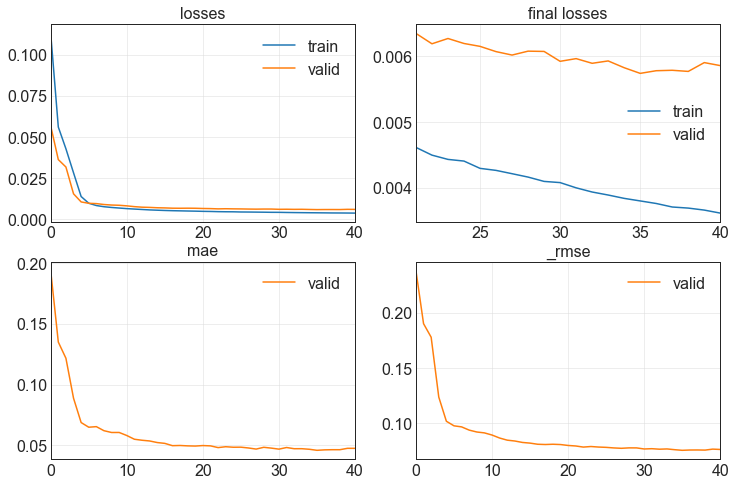

24.63510298728943                                                                                                      
[0.00361049035564065, 0.005856164265424013, 0.04756142944097519, 0.07652557641267776]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 30%|█████████████▏                              | 30/100 [09:39<27:02, 23.18s/trial, best loss: 0.0056266700848937035]

No improvement since epoch 55: early stopping                                                                          
 30%|█████████████▏                              | 30/100 [10:15<27:02, 23.18s/trial, best loss: 0.0056266700848937035]

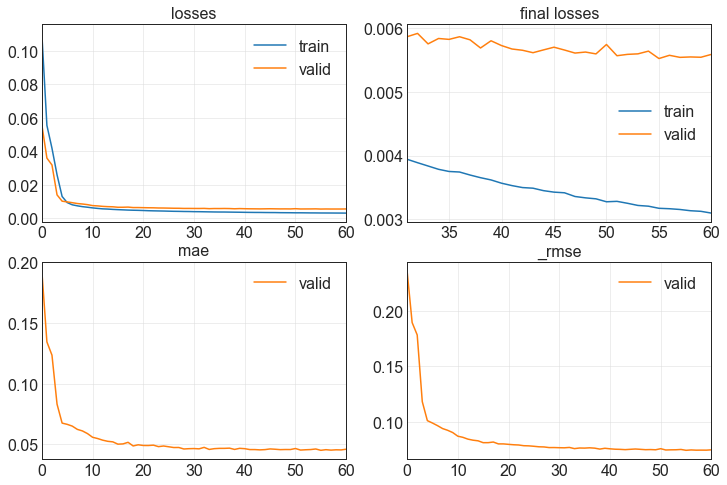

36.53355956077576                                                                                                      
[0.003099909285083413, 0.005586214363574982, 0.04609322175383568, 0.07474098354578018]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 31%|█████████████▉                               | 31/100 [10:16<31:38, 27.52s/trial, best loss: 0.005586214363574982]

No improvement since epoch 51: early stopping                                                                          
 31%|█████████████▉                               | 31/100 [10:50<31:38, 27.52s/trial, best loss: 0.005586214363574982]

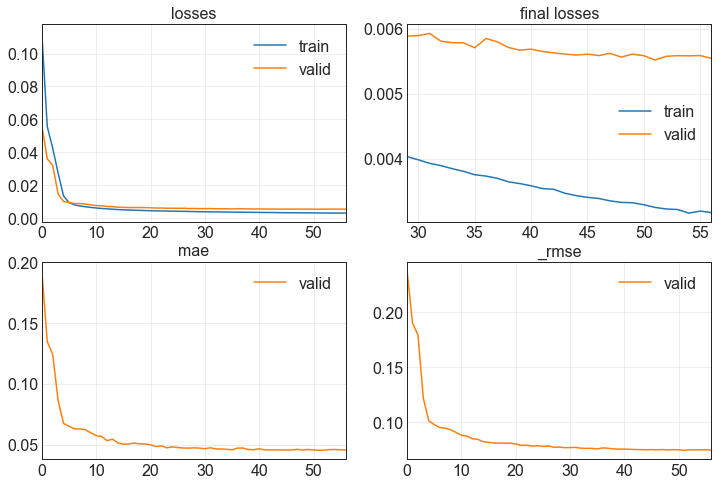

34.14857029914856                                                                                                      
[0.0031705207657068968, 0.005542377475649118, 0.045483313500881195, 0.0744471475481987]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 32%|██████████████▍                              | 32/100 [10:52<33:48, 29.83s/trial, best loss: 0.005542377475649118]

No improvement since epoch 50: early stopping                                                                          
 32%|██████████████▍                              | 32/100 [11:25<33:48, 29.83s/trial, best loss: 0.005542377475649118]

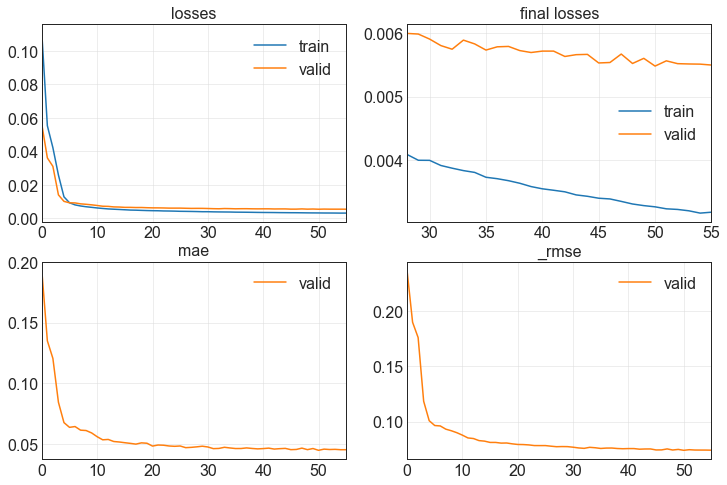

33.61747860908508                                                                                                      
[0.003178216051310301, 0.0054975273087620735, 0.04521386697888374, 0.07414530962705612]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 33%|██████████████▌                             | 33/100 [11:26<34:56, 31.29s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 48: early stopping                                                                          
 33%|██████████████▌                             | 33/100 [11:58<34:56, 31.29s/trial, best loss: 0.0054975273087620735]

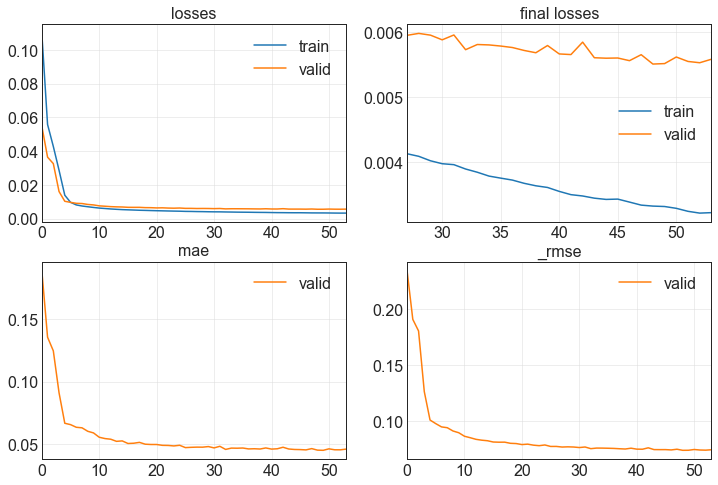

32.52654242515564                                                                                                      
[0.0032287149224430323, 0.005580639000982046, 0.045851610600948334, 0.07470367103815079]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 34%|██████████████▉                             | 34/100 [12:00<35:11, 31.99s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 43: early stopping                                                                          
 34%|██████████████▉                             | 34/100 [12:29<35:11, 31.99s/trial, best loss: 0.0054975273087620735]

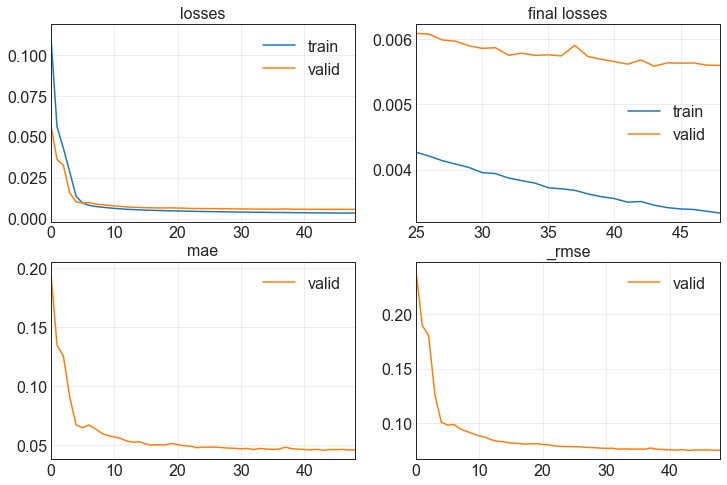

29.408012866973877                                                                                                     
[0.0033343068789690733, 0.005594397895038128, 0.0456225648522377, 0.07479570806026459]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 35%|███████████████▍                            | 35/100 [12:30<34:10, 31.54s/trial, best loss: 0.0054975273087620735]

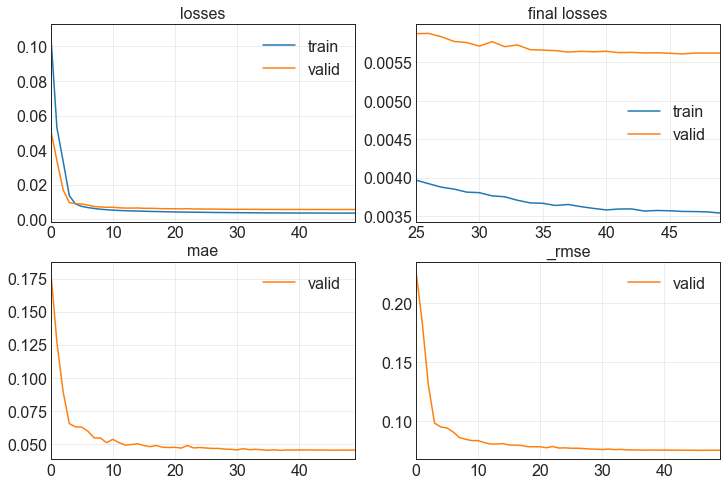

29.994065523147583                                                                                                     
[0.003537358483299613, 0.0056214104406535625, 0.04534725472331047, 0.07497607171535492]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 36%|███████████████▊                            | 36/100 [13:02<33:30, 31.41s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 69: early stopping                                                                          
 36%|███████████████▊                            | 36/100 [13:47<33:30, 31.41s/trial, best loss: 0.0054975273087620735]

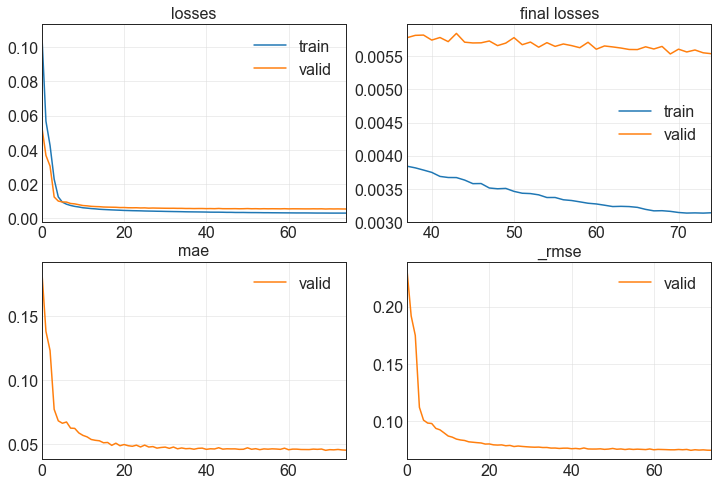

45.387690782547                                                                                                        
[0.0031404341571033, 0.005536285229027271, 0.04503275826573372, 0.0744062140583992]                                    
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 37%|████████████████▎                           | 37/100 [13:48<37:43, 35.93s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 48: early stopping                                                                          
 37%|████████████████▎                           | 37/100 [14:20<37:43, 35.93s/trial, best loss: 0.0054975273087620735]

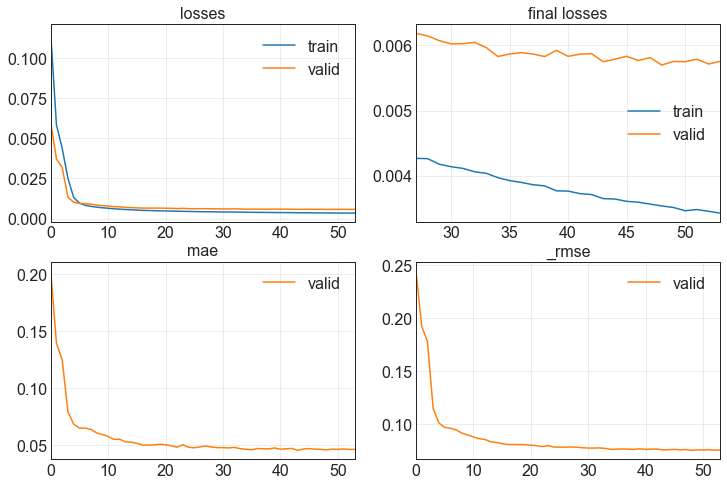

32.47558307647705                                                                                                      
[0.0034225499257445335, 0.00575734069570899, 0.046081461012363434, 0.07587714493274689]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 38%|████████████████▋                           | 38/100 [14:22<36:24, 35.23s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 1: early stopping                                                                           
 38%|████████████████▋                           | 38/100 [14:37<36:24, 35.23s/trial, best loss: 0.0054975273087620735]

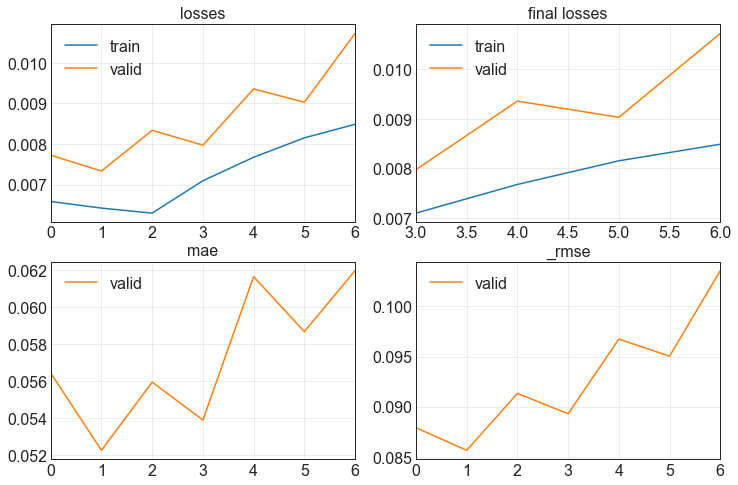

15.353228569030762                                                                                                     
[0.008487476967275143, 0.010727266781032085, 0.06198267638683319, 0.10357252508401871]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 39%|█████████████████▏                          | 39/100 [14:38<30:05, 29.59s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 70: early stopping                                                                          
 39%|█████████████████▏                          | 39/100 [15:22<30:05, 29.59s/trial, best loss: 0.0054975273087620735]

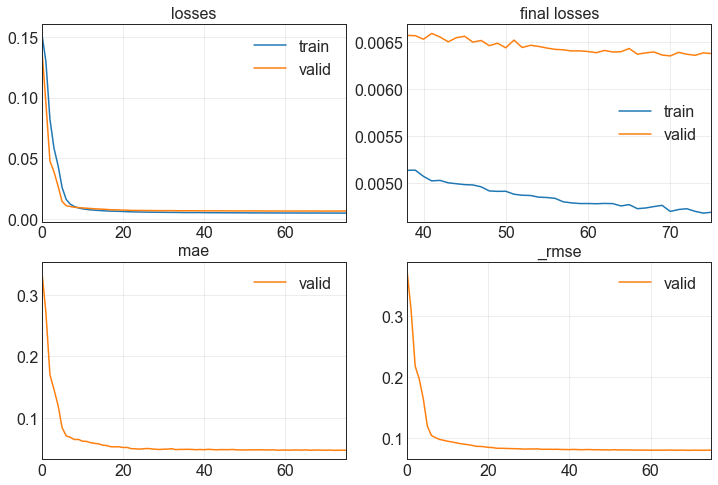

44.252054929733276                                                                                                     
[0.004686946049332619, 0.006381188984960318, 0.047852009534835815, 0.07988233864307404]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 40%|█████████████████▌                          | 40/100 [15:23<34:19, 34.32s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 60: early stopping                                                                          
 40%|█████████████████▌                          | 40/100 [16:03<34:19, 34.32s/trial, best loss: 0.0054975273087620735]

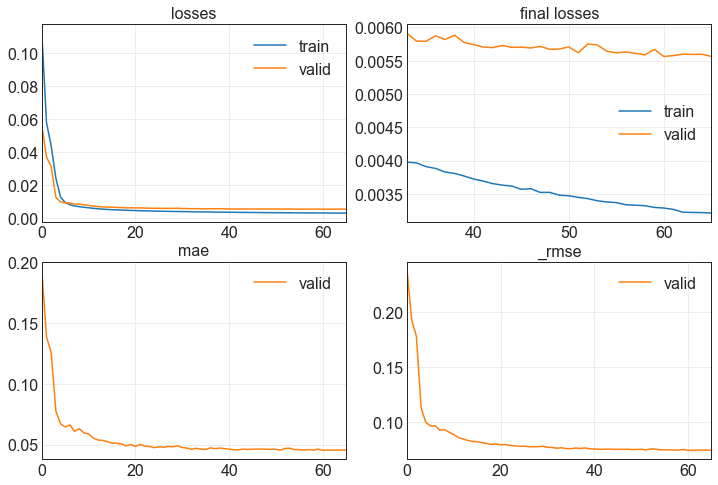

39.84612202644348                                                                                                      
[0.0032131816260516644, 0.005565018858760595, 0.045494500547647476, 0.07459905743598938]                               
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 41%|██████████████████                          | 41/100 [16:04<35:41, 36.30s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 0: early stopping                                                                           
 41%|██████████████████                          | 41/100 [16:17<35:41, 36.30s/trial, best loss: 0.0054975273087620735]

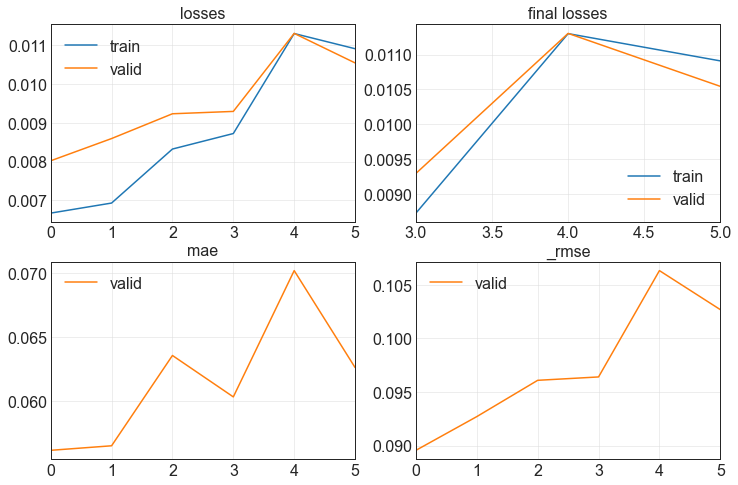

13.122480154037476                                                                                                     
[0.010910806246101856, 0.010544988326728344, 0.06262274086475372, 0.10268878191709518]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 42%|██████████████████▍                         | 42/100 [16:19<28:41, 29.69s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 61: early stopping                                                                          
 42%|██████████████████▍                         | 42/100 [17:31<28:41, 29.69s/trial, best loss: 0.0054975273087620735]

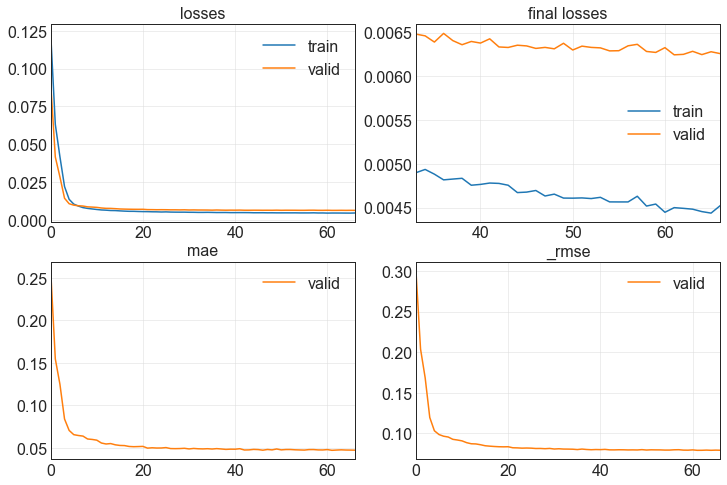

72.74956154823303                                                                                                      
[0.00452303234487772, 0.006260057911276817, 0.04719500616192818, 0.07912052422761917]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 43%|██████████████████▉                         | 43/100 [17:32<40:46, 42.93s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 44: early stopping                                                                          
 43%|██████████████████▉                         | 43/100 [18:02<40:46, 42.93s/trial, best loss: 0.0054975273087620735]

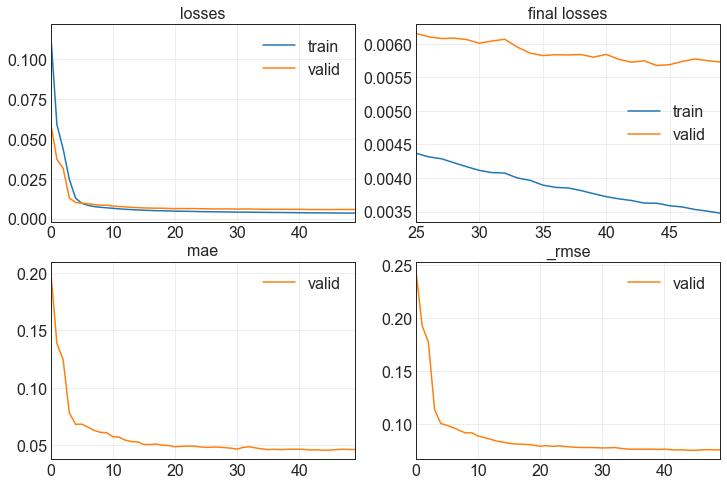

29.96761155128479                                                                                                      
[0.0034765172749757767, 0.005728617310523987, 0.046118929982185364, 0.07568763196468353]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 44%|███████████████████▎                        | 44/100 [18:03<36:44, 39.37s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 3: early stopping                                                                           
 44%|███████████████████▎                        | 44/100 [18:09<36:44, 39.37s/trial, best loss: 0.0054975273087620735]

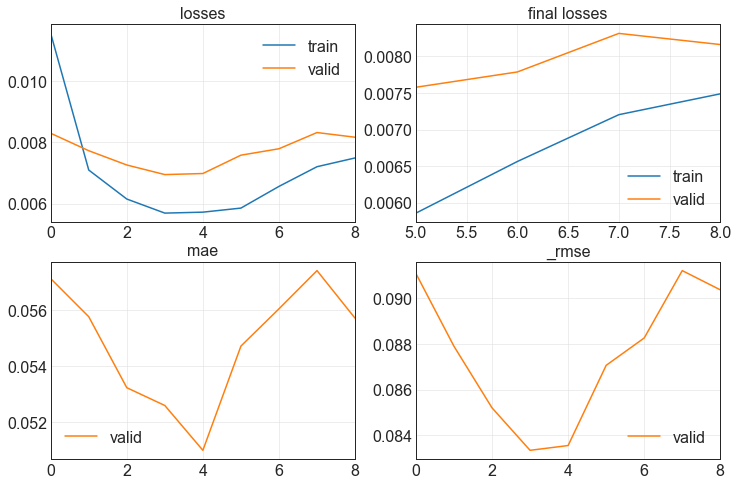

5.72922682762146                                                                                                       
[0.007489217445254326, 0.008163574151694775, 0.05572177842259407, 0.09035249799489975]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 45%|███████████████████▊                        | 45/100 [18:10<27:08, 29.61s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 30: early stopping                                                                          
 45%|███████████████████▊                        | 45/100 [19:26<27:08, 29.61s/trial, best loss: 0.0054975273087620735]

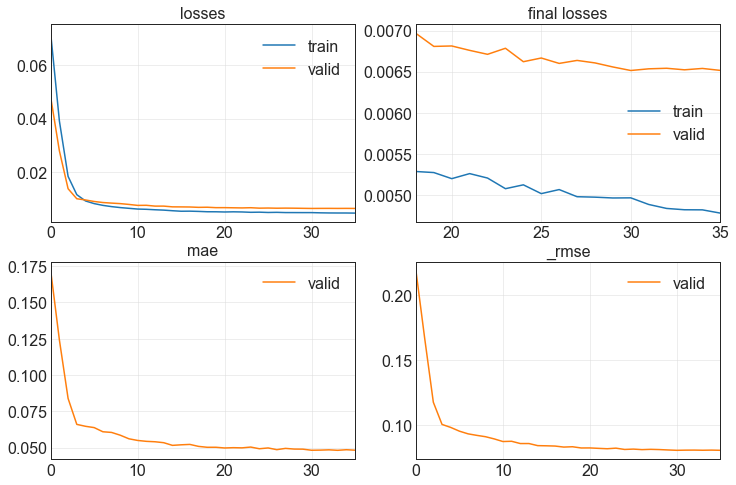

76.47897505760193                                                                                                      
[0.004777675028890371, 0.006515858229249716, 0.04826505482196808, 0.08072085678577423]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 46%|████████████████████▏                       | 46/100 [19:28<39:35, 43.99s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 5: early stopping                                                                           
 46%|████████████████████▏                       | 46/100 [19:40<39:35, 43.99s/trial, best loss: 0.0054975273087620735]

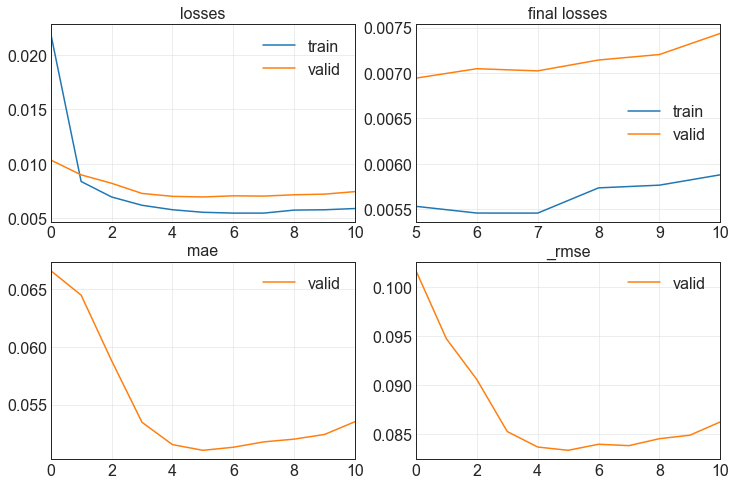

12.183148622512817                                                                                                     
[0.005878977477550507, 0.007435705047100782, 0.05352820083498955, 0.08623053133487701]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 47%|████████████████████▋                       | 47/100 [19:41<30:43, 34.78s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 3: early stopping                                                                           
 47%|████████████████████▋                       | 47/100 [19:46<30:43, 34.78s/trial, best loss: 0.0054975273087620735]

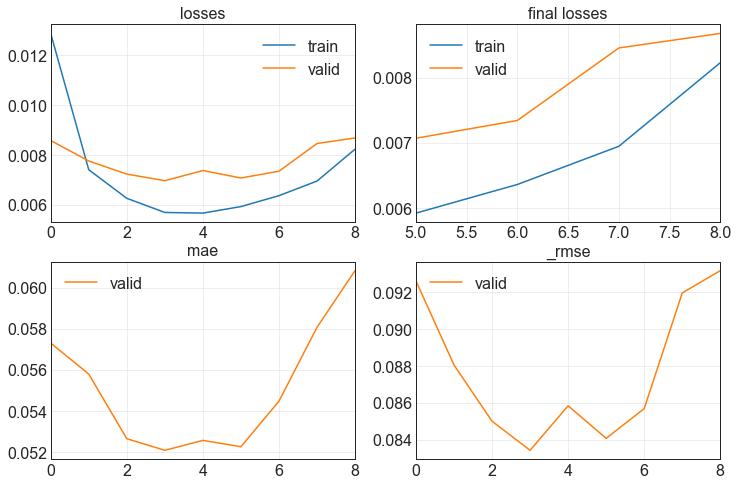

5.746655464172363                                                                                                      
[0.008228222839534283, 0.008678584359586239, 0.0608263835310936, 0.09315892308950424]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 48%|█████████████████████                       | 48/100 [19:48<22:52, 26.40s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 34: early stopping                                                                          
 48%|█████████████████████                       | 48/100 [20:11<22:52, 26.40s/trial, best loss: 0.0054975273087620735]

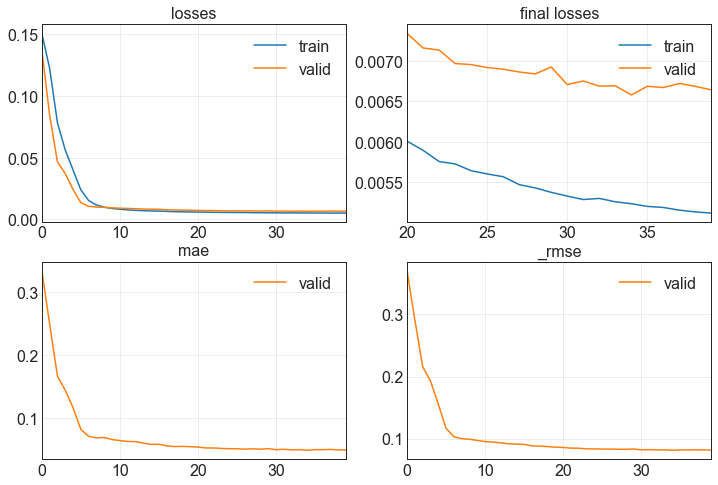

23.26022171974182                                                                                                      
[0.005114313215017319, 0.00664428249001503, 0.04898076876997948, 0.0815124660730362]                                   
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 49%|█████████████████████▌                      | 49/100 [20:12<21:55, 25.79s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 5: early stopping                                                                           
 49%|█████████████████████▌                      | 49/100 [20:25<21:55, 25.79s/trial, best loss: 0.0054975273087620735]

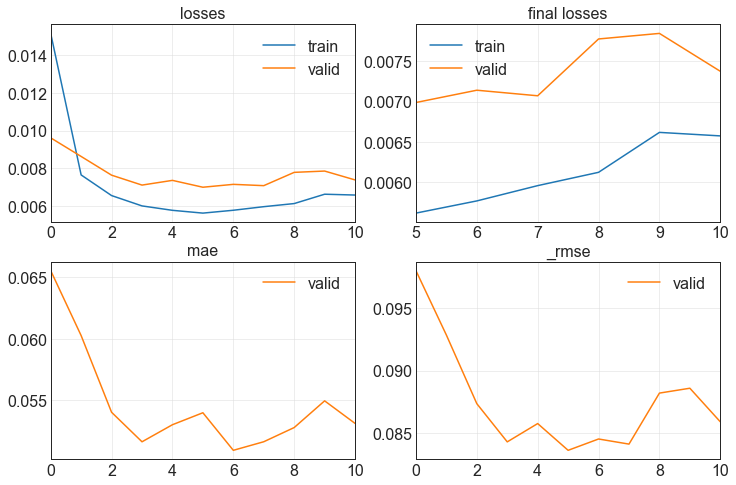

12.756141185760498                                                                                                     
[0.006573604419827461, 0.0073763784021139145, 0.053134750574827194, 0.08588584512472153]                               
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 50%|██████████████████████                      | 50/100 [20:26<18:30, 22.21s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 62: early stopping                                                                          
 50%|██████████████████████                      | 50/100 [23:03<18:30, 22.21s/trial, best loss: 0.0054975273087620735]

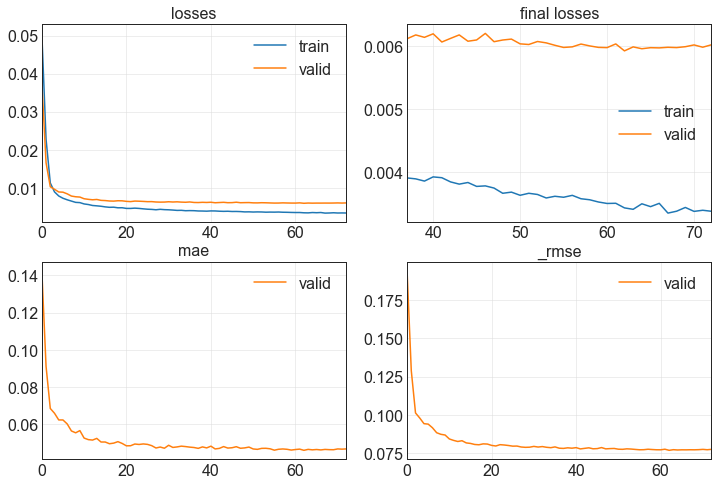

157.25273489952087                                                                                                     
[0.0033764203544706106, 0.0060270666144788265, 0.04673432931303978, 0.07763416320085526]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 51%|██████████████████████▍                     | 51/100 [23:05<51:29, 63.05s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 3: early stopping                                                                           
 51%|██████████████████████▍                     | 51/100 [23:10<51:29, 63.05s/trial, best loss: 0.0054975273087620735]

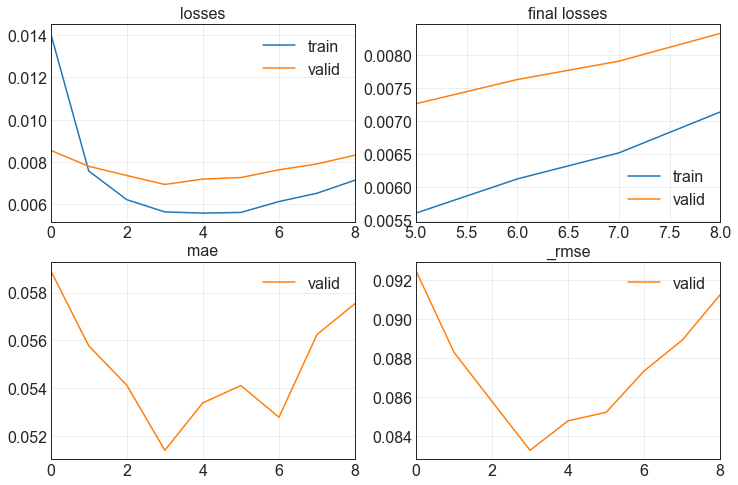

5.732123136520386                                                                                                      
[0.007140867877751589, 0.00832702498883009, 0.05754394829273224, 0.09125254303216934]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 52%|██████████████████████▉                     | 52/100 [23:11<36:57, 46.19s/trial, best loss: 0.0054975273087620735]

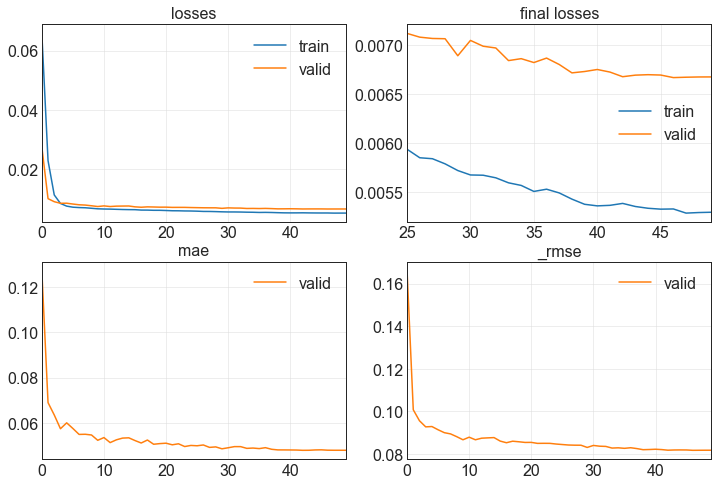

29.08673644065857                                                                                                      
[0.005295855458825827, 0.006676763296127319, 0.04794774577021599, 0.08171146363019943]                                 
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 53%|███████████████████████▎                    | 53/100 [23:42<32:25, 41.39s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 32: early stopping                                                                          
 53%|███████████████████████▎                    | 53/100 [24:25<32:25, 41.39s/trial, best loss: 0.0054975273087620735]

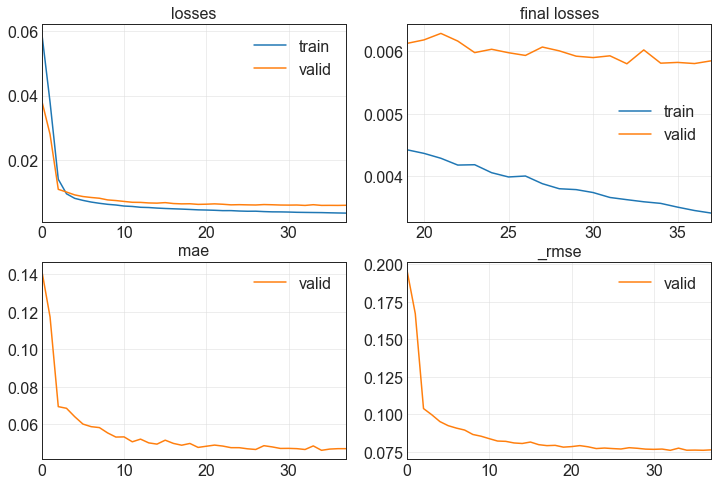

43.39143490791321                                                                                                      
[0.003409302793443203, 0.005848630331456661, 0.04694480448961258, 0.07647634297609329]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 54%|███████████████████████▊                    | 54/100 [24:26<32:26, 42.32s/trial, best loss: 0.0054975273087620735]

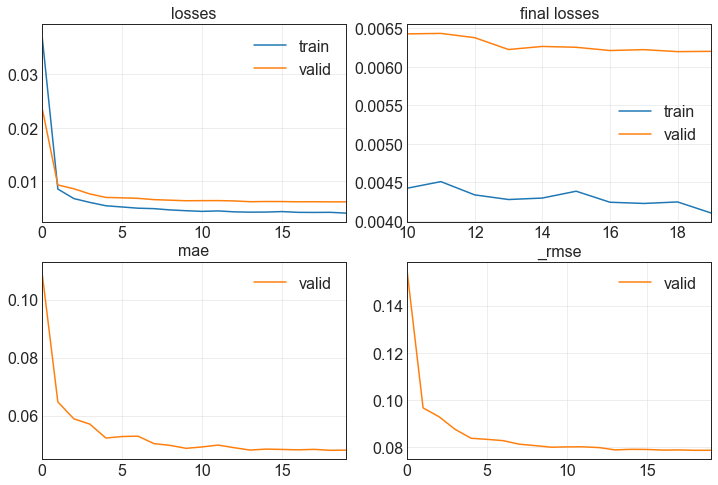

42.93593144416809                                                                                                      
[0.004101909697055817, 0.0062022279016673565, 0.04807830601930618, 0.0787542313337326]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 55%|████████████████████████▏                   | 55/100 [25:10<32:07, 42.84s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 10: early stopping                                                                          
 55%|████████████████████████▏                   | 55/100 [25:23<32:07, 42.84s/trial, best loss: 0.0054975273087620735]

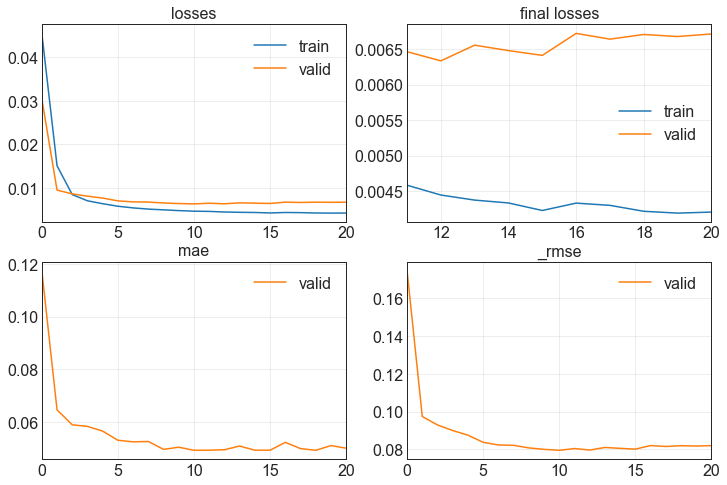

12.874438524246216                                                                                                     
[0.004207194317132235, 0.006712057162076235, 0.05005919933319092, 0.08192715048789978]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 56%|████████████████████████▋                   | 56/100 [25:24<25:03, 34.18s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 1: early stopping                                                                           
 56%|████████████████████████▋                   | 56/100 [25:28<25:03, 34.18s/trial, best loss: 0.0054975273087620735]

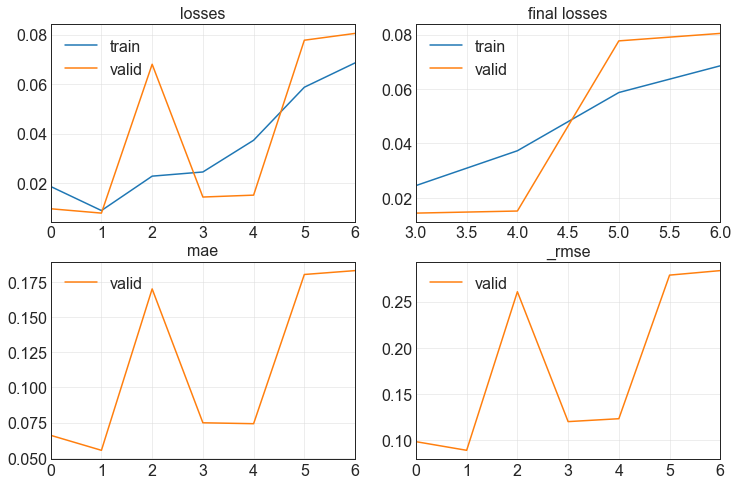

4.625702381134033                                                                                                      
[0.06855146586894989, 0.08046409487724304, 0.18292801082134247, 0.2836619019508362]                                    
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 50, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 57%|█████████████████████████                   | 57/100 [25:30<18:22, 25.64s/trial, best loss: 0.0054975273087620735]

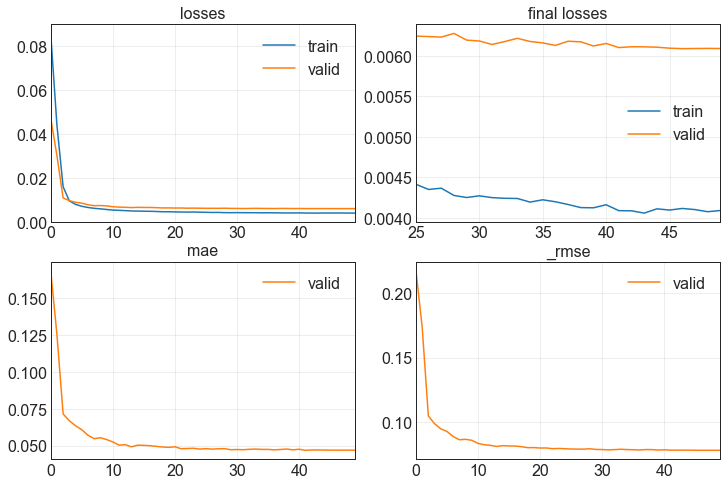

54.545774698257446                                                                                                     
[0.004089122172445059, 0.006089386064559221, 0.046884648501873016, 0.07803452759981155]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 58%|█████████████████████████▌                  | 58/100 [26:25<24:14, 34.63s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 85: early stopping                                                                          
 58%|█████████████████████████▌                  | 58/100 [27:21<24:14, 34.63s/trial, best loss: 0.0054975273087620735]

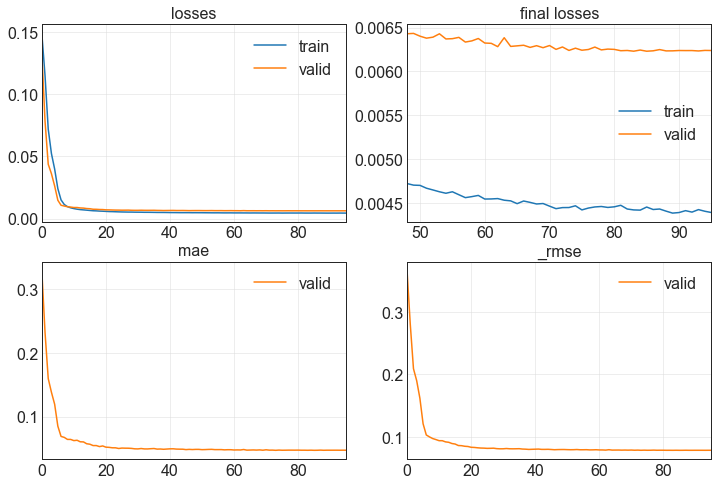

55.98752784729004                                                                                                      
[0.004389048088341951, 0.006239366251975298, 0.04712776467204094, 0.0789896622300148]                                  
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 59%|█████████████████████████▉                  | 59/100 [27:23<28:16, 41.37s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 13: early stopping                                                                          
 59%|█████████████████████████▉                  | 59/100 [27:29<28:16, 41.37s/trial, best loss: 0.0054975273087620735]

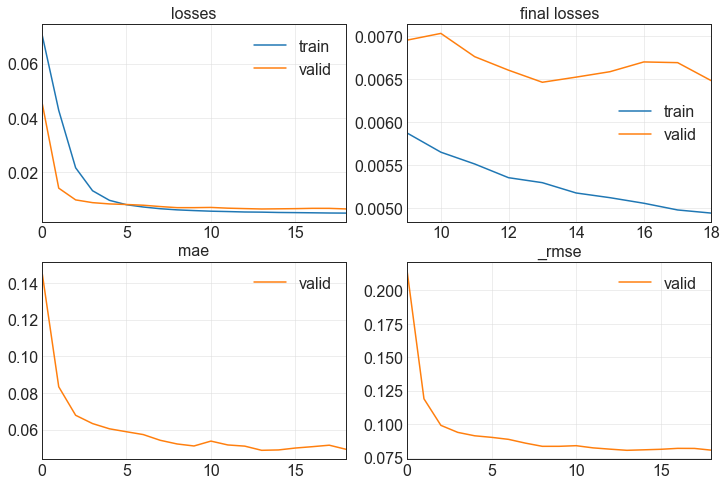

6.859172582626343                                                                                                      
[0.004941796418279409, 0.006479174364358187, 0.04922785609960556, 0.08049331605434418]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 60%|██████████████████████████▍                 | 60/100 [27:31<20:54, 31.35s/trial, best loss: 0.0054975273087620735]

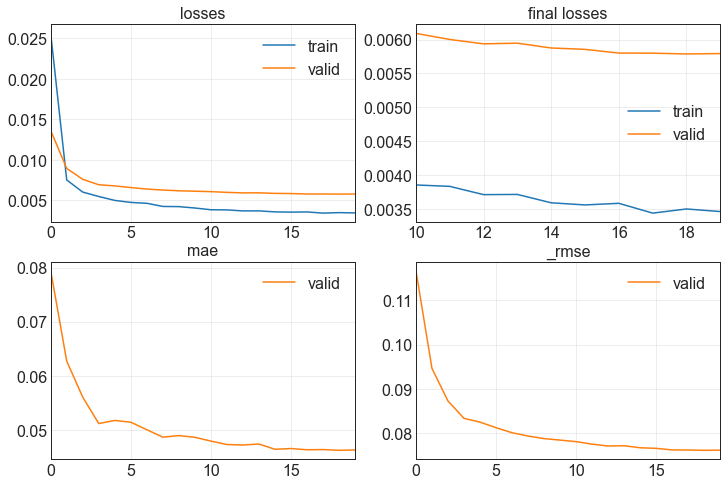

43.19930052757263                                                                                                      
[0.003466822672635317, 0.005792760290205479, 0.0462869368493557, 0.07611019164323807]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.2, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 61%|██████████████████████████▊                 | 61/100 [28:15<22:54, 35.24s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 61: early stopping                                                                          
 61%|██████████████████████████▊                 | 61/100 [28:57<22:54, 35.24s/trial, best loss: 0.0054975273087620735]

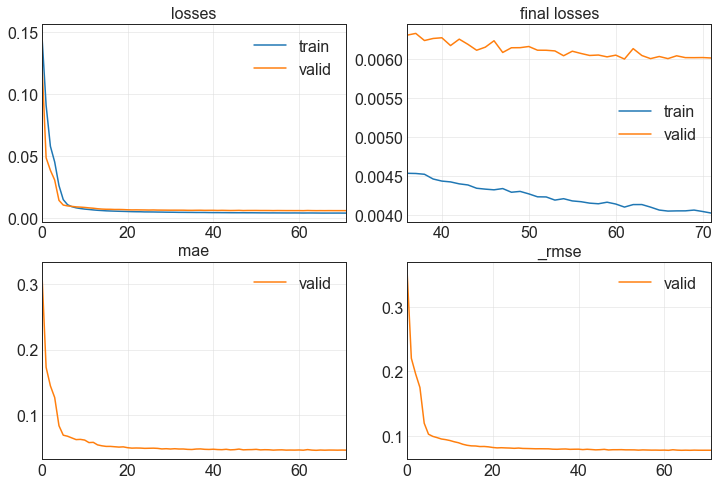

42.48306202888489                                                                                                      
[0.004029155243188143, 0.00601768447086215, 0.04655415937304497, 0.0775737389922142]                                   
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 62%|███████████████████████████▎                | 62/100 [28:58<23:54, 37.75s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 5: early stopping                                                                           
 62%|███████████████████████████▎                | 62/100 [29:05<23:54, 37.75s/trial, best loss: 0.0054975273087620735]

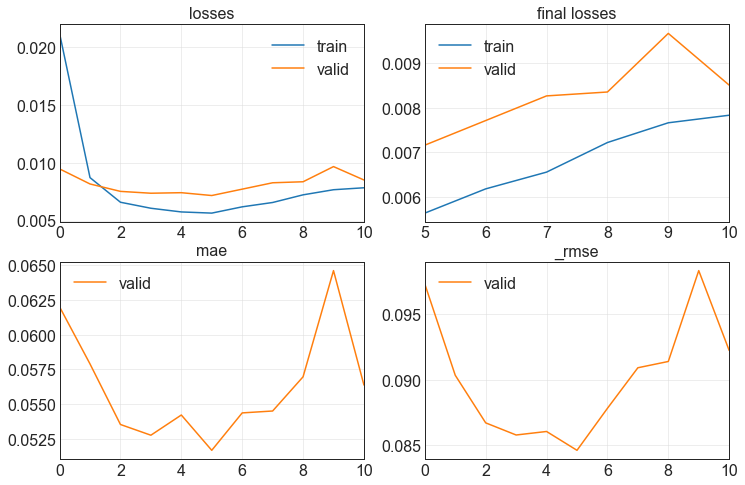

6.958688497543335                                                                                                      
[0.007833197712898254, 0.008507234044373035, 0.05637997016310692, 0.09223467111587524]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 63%|███████████████████████████▋                | 63/100 [29:06<17:47, 28.84s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 40: early stopping                                                                          
 63%|███████████████████████████▋                | 63/100 [29:21<17:47, 28.84s/trial, best loss: 0.0054975273087620735]

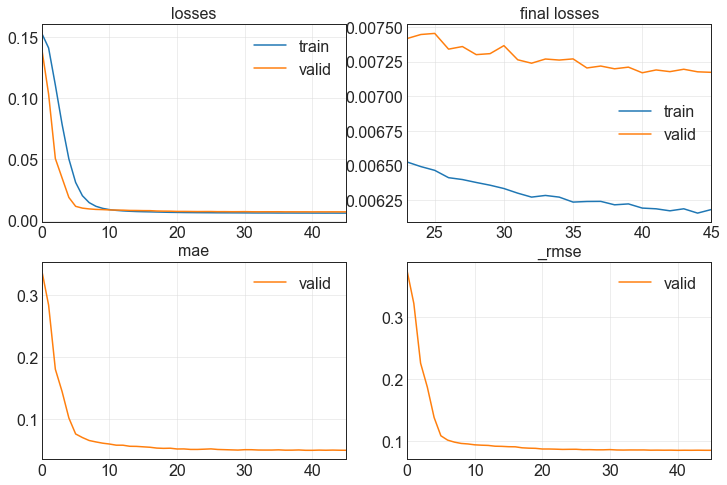

15.255277395248413                                                                                                     
[0.006180643104016781, 0.007172886282205582, 0.0503079891204834, 0.08469288796186447]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 64%|████████████████████████████▏               | 64/100 [29:23<15:03, 25.09s/trial, best loss: 0.0054975273087620735]

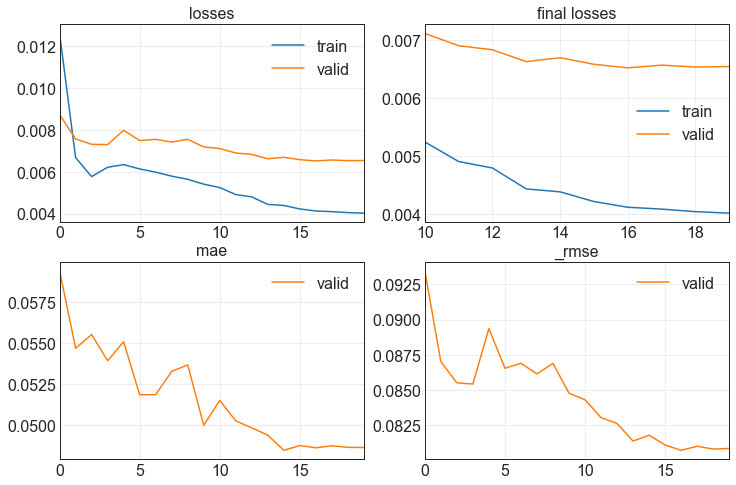

23.075394868850708                                                                                                     
[0.004023551009595394, 0.006540034897625446, 0.0486585833132267, 0.08087048679590225]                                  
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 65%|████████████████████████████▌               | 65/100 [29:47<14:28, 24.82s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 48: early stopping                                                                          
 65%|████████████████████████████▌               | 65/100 [30:19<14:28, 24.82s/trial, best loss: 0.0054975273087620735]

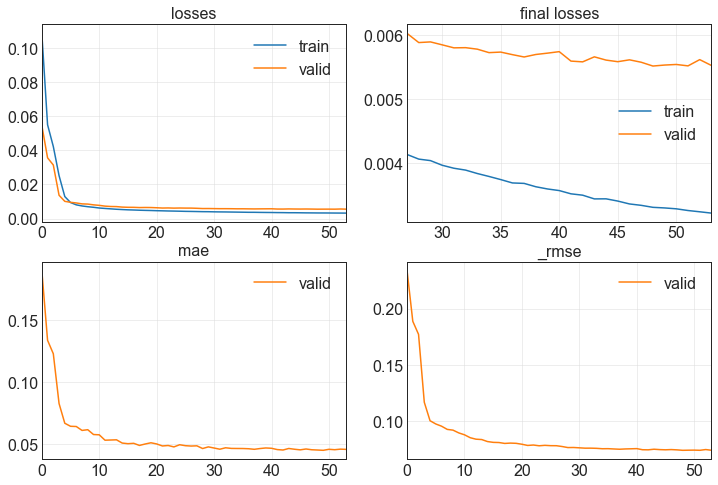

32.69375991821289                                                                                                      
[0.0032127811573445797, 0.005527228582650423, 0.04577936232089996, 0.07434532791376114]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 66%|█████████████████████████████               | 66/100 [30:21<15:35, 27.51s/trial, best loss: 0.0054975273087620735]

No improvement since epoch 63: early stopping                                                                          
 66%|█████████████████████████████               | 66/100 [31:02<15:35, 27.51s/trial, best loss: 0.0054975273087620735]

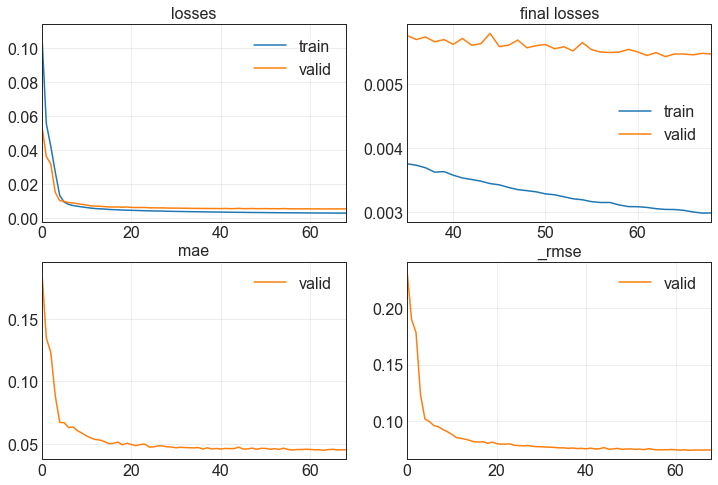

41.31784510612488                                                                                                      
[0.002981591736897826, 0.005463892128318548, 0.04516866058111191, 0.07391814142465591]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 67%|██████████████████████████████▏              | 67/100 [31:03<17:35, 31.98s/trial, best loss: 0.005463892128318548]

No improvement since epoch 43: early stopping                                                                          
 67%|██████████████████████████████▏              | 67/100 [31:32<17:35, 31.98s/trial, best loss: 0.005463892128318548]

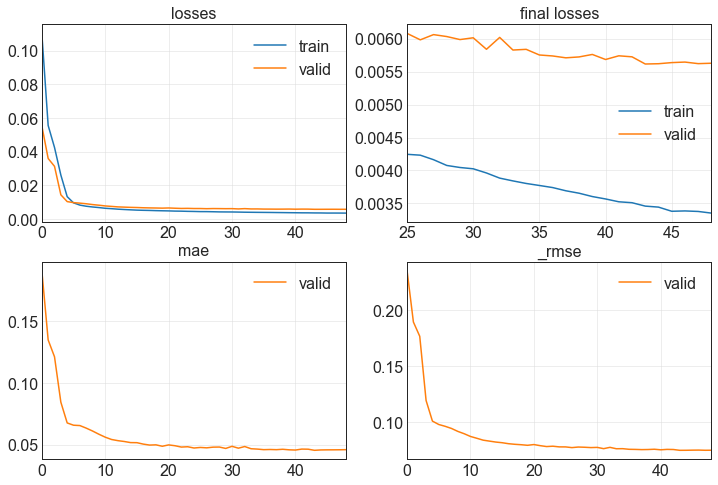

29.47962474822998                                                                                                      
[0.0033533794339746237, 0.0056270454078912735, 0.04586149752140045, 0.07501363754272461]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 68%|██████████████████████████████▌              | 68/100 [31:34<16:50, 31.56s/trial, best loss: 0.005463892128318548]

No improvement since epoch 44: early stopping                                                                          
 68%|██████████████████████████████▌              | 68/100 [32:03<16:50, 31.56s/trial, best loss: 0.005463892128318548]

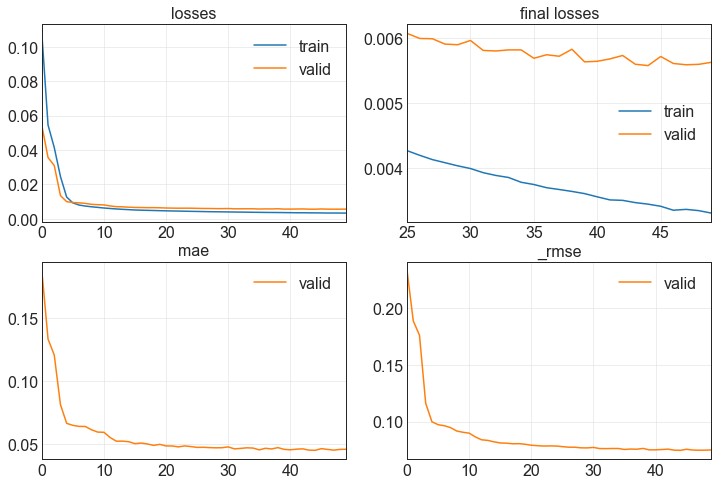

30.095032453536987                                                                                                     
[0.003303691977635026, 0.0056283301673829556, 0.04575810953974724, 0.07502220571041107]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 69%|███████████████████████████████              | 69/100 [32:05<16:15, 31.46s/trial, best loss: 0.005463892128318548]

No improvement since epoch 43: early stopping                                                                          
 69%|███████████████████████████████              | 69/100 [32:34<16:15, 31.46s/trial, best loss: 0.005463892128318548]

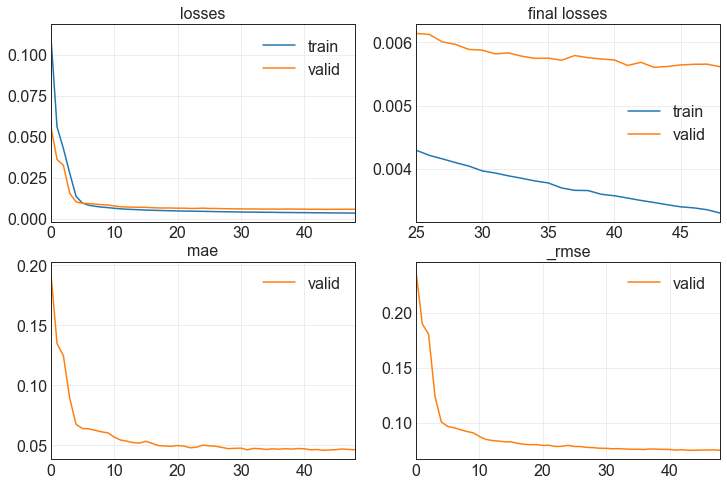

29.472345113754272                                                                                                     
[0.003297744784504175, 0.005612771026790142, 0.04586012288928032, 0.07491842657327652]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 70%|███████████████████████████████▍             | 70/100 [32:36<15:35, 31.19s/trial, best loss: 0.005463892128318548]

No improvement since epoch 37: early stopping                                                                          
 70%|███████████████████████████████▍             | 70/100 [33:01<15:35, 31.19s/trial, best loss: 0.005463892128318548]

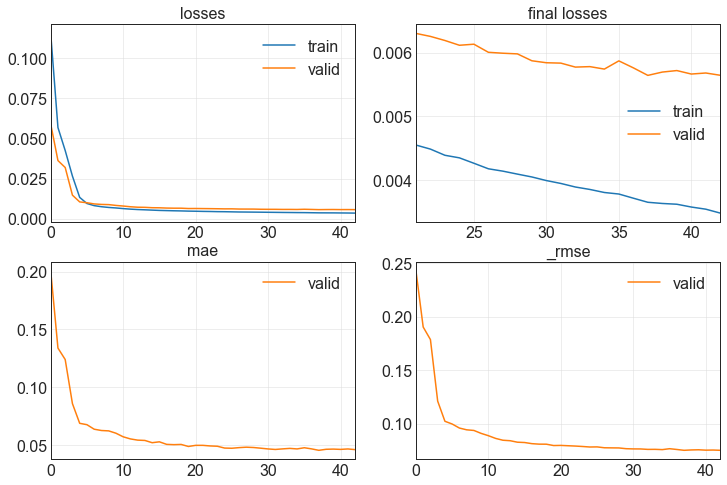

25.96426796913147                                                                                                      
[0.0034760464914143085, 0.005643803626298904, 0.045843325555324554, 0.07512524724006653]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 71%|███████████████████████████████▉             | 71/100 [33:03<14:28, 29.95s/trial, best loss: 0.005463892128318548]

No improvement since epoch 42: early stopping                                                                          
 71%|███████████████████████████████▉             | 71/100 [33:31<14:28, 29.95s/trial, best loss: 0.005463892128318548]

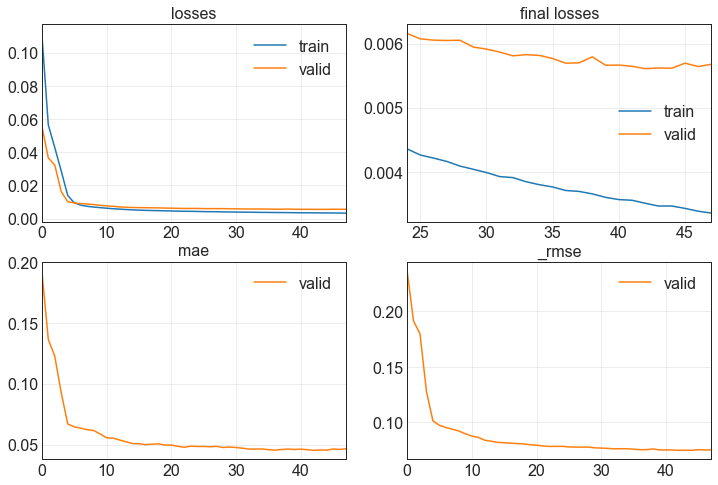

28.938084840774536                                                                                                     
[0.0033547517377883196, 0.005676756147295237, 0.046475622802972794, 0.07534424960613251]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 72%|████████████████████████████████▍            | 72/100 [33:33<13:59, 29.98s/trial, best loss: 0.005463892128318548]

No improvement since epoch 42: early stopping                                                                          
 72%|████████████████████████████████▍            | 72/100 [34:01<13:59, 29.98s/trial, best loss: 0.005463892128318548]

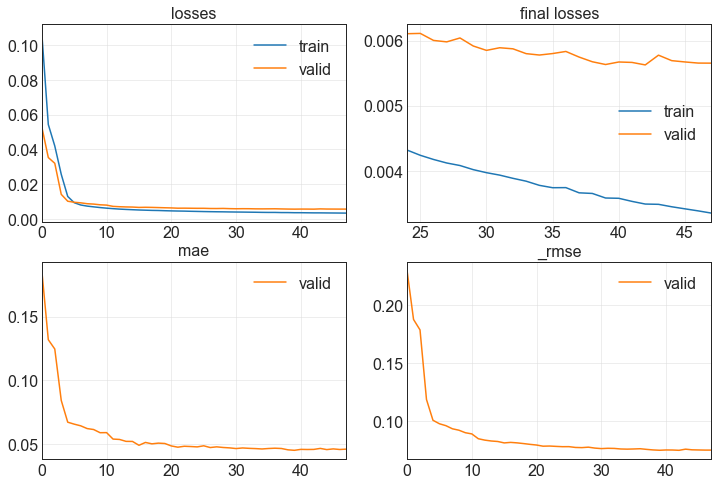

28.952038764953613                                                                                                     
[0.003348842030391097, 0.005653966683894396, 0.04613363742828369, 0.07519286870956421]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 73%|████████████████████████████████▊            | 73/100 [34:03<13:29, 30.00s/trial, best loss: 0.005463892128318548]

No improvement since epoch 51: early stopping                                                                          
 73%|████████████████████████████████▊            | 73/100 [34:37<13:29, 30.00s/trial, best loss: 0.005463892128318548]

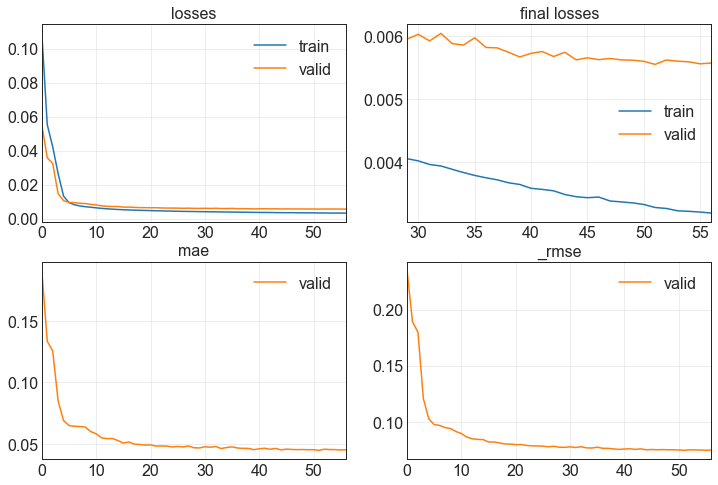

34.31862282752991                                                                                                      
[0.0031895781867206097, 0.005570812616497278, 0.04530462995171547, 0.07463788241147995]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 74%|█████████████████████████████████▎           | 74/100 [34:38<13:42, 31.63s/trial, best loss: 0.005463892128318548]

No improvement since epoch 36: early stopping                                                                          
 74%|█████████████████████████████████▎           | 74/100 [35:03<13:42, 31.63s/trial, best loss: 0.005463892128318548]

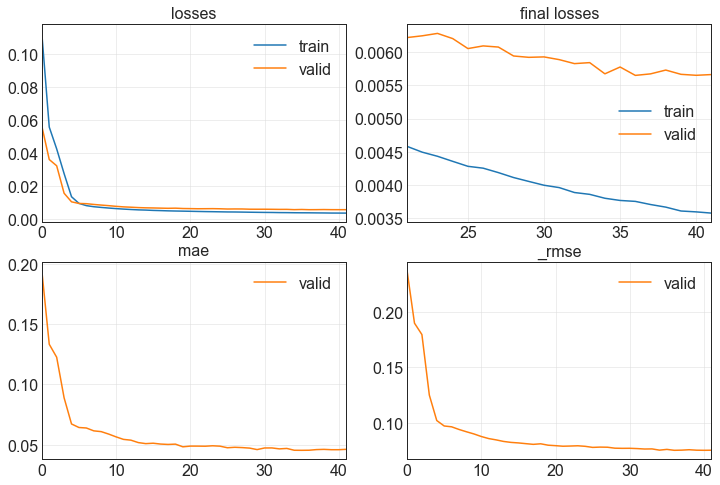

25.351946592330933                                                                                                     
[0.003578934585675597, 0.005662438925355673, 0.04618294537067413, 0.07524918019771576]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 75%|█████████████████████████████████▊           | 75/100 [35:05<12:31, 30.07s/trial, best loss: 0.005463892128318548]

No improvement since epoch 75: early stopping                                                                          
 75%|█████████████████████████████████▊           | 75/100 [35:31<12:31, 30.07s/trial, best loss: 0.005463892128318548]

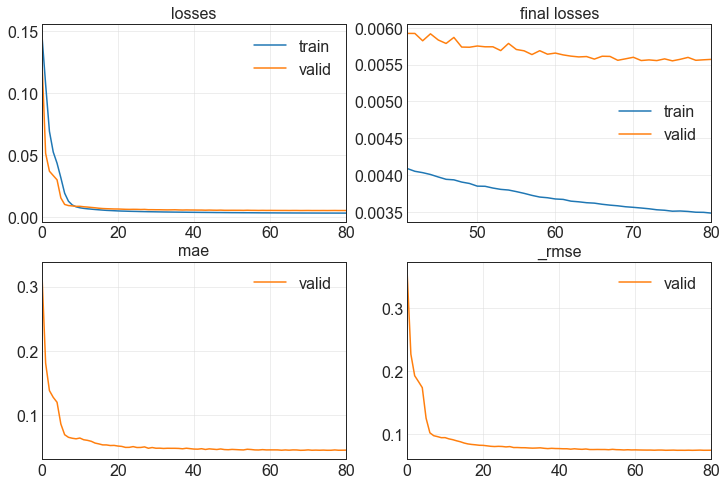

27.24964141845703                                                                                                      
[0.0034825357142835855, 0.0055723534896969795, 0.045069195330142975, 0.07464819401502609]                              
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 76%|██████████████████████████████████▏          | 76/100 [35:33<11:49, 29.55s/trial, best loss: 0.005463892128318548]

No improvement since epoch 58: early stopping                                                                          
 76%|██████████████████████████████████▏          | 76/100 [36:11<11:49, 29.55s/trial, best loss: 0.005463892128318548]

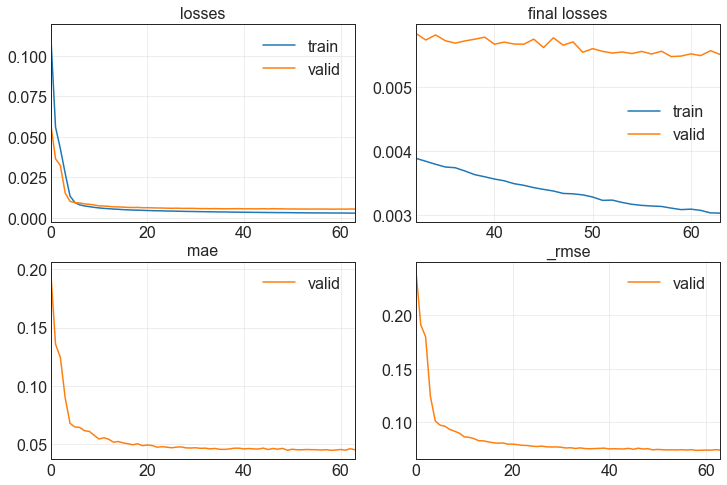

38.45771336555481                                                                                                      
[0.0030328663997352123, 0.005508719477802515, 0.04543352499604225, 0.07422074675559998]                                
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 77%|██████████████████████████████████▋          | 77/100 [36:12<12:28, 32.55s/trial, best loss: 0.005463892128318548]

No improvement since epoch 28: early stopping                                                                          
 77%|██████████████████████████████████▋          | 77/100 [37:25<12:28, 32.55s/trial, best loss: 0.005463892128318548]

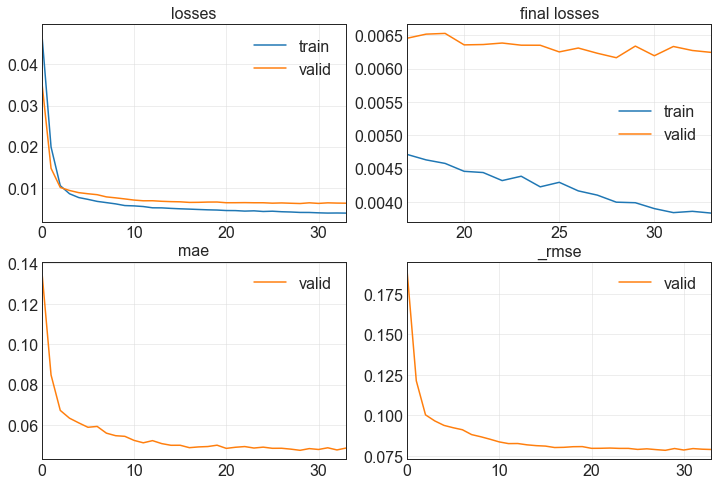

73.33182787895203                                                                                                      
[0.0038310016971081495, 0.006241986993700266, 0.04867730289697647, 0.07900624722242355]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 78%|███████████████████████████████████          | 78/100 [37:27<16:32, 45.12s/trial, best loss: 0.005463892128318548]

No improvement since epoch 1: early stopping                                                                           
 78%|███████████████████████████████████          | 78/100 [37:31<16:32, 45.12s/trial, best loss: 0.005463892128318548]

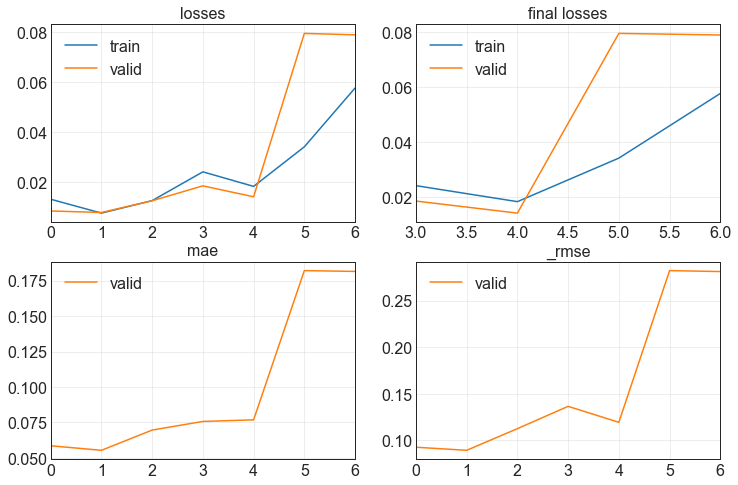

4.659000873565674                                                                                                      
[0.057779815047979355, 0.0790645107626915, 0.18152843415737152, 0.2811841368675232]                                    
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 79%|███████████████████████████████████▌         | 79/100 [37:33<11:39, 33.31s/trial, best loss: 0.005463892128318548]

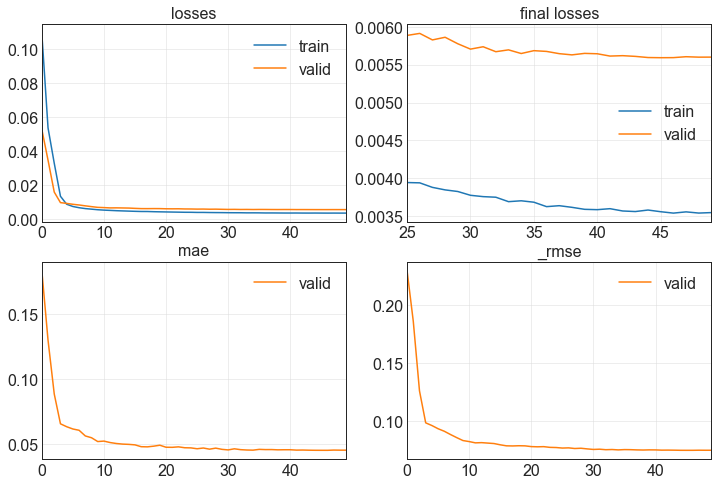

30.26987600326538                                                                                                      
[0.0035469061695039272, 0.00559987360611558, 0.04513902962207794, 0.07483230531215668]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 80%|████████████████████████████████████         | 80/100 [38:04<10:54, 32.73s/trial, best loss: 0.005463892128318548]

No improvement since epoch 31: early stopping                                                                          
 80%|████████████████████████████████████         | 80/100 [38:25<10:54, 32.73s/trial, best loss: 0.005463892128318548]

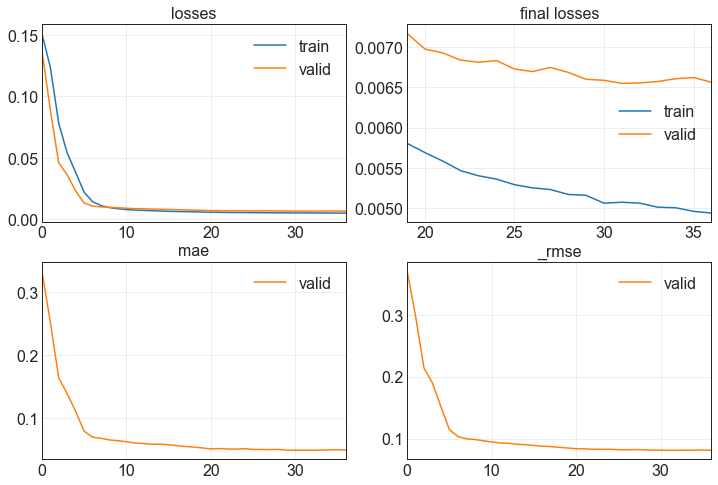

21.6938259601593                                                                                                       
[0.0049377609975636005, 0.006563730537891388, 0.049090929329395294, 0.08101685345172882]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 81%|████████████████████████████████████▍        | 81/100 [38:27<09:25, 29.75s/trial, best loss: 0.005463892128318548]

No improvement since epoch 39: early stopping                                                                          
 81%|████████████████████████████████████▍        | 81/100 [38:43<09:25, 29.75s/trial, best loss: 0.005463892128318548]

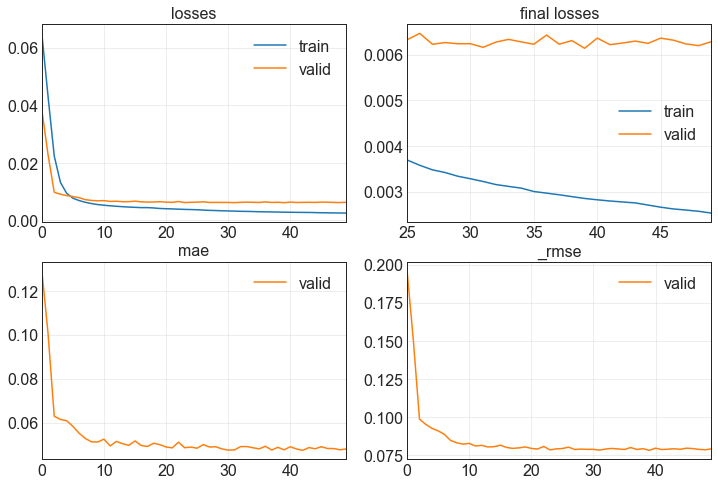

16.99226450920105                                                                                                      
[0.002532011829316616, 0.0062829116359353065, 0.048000045120716095, 0.0792648121714592]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 82%|████████████████████████████████████▉        | 82/100 [38:45<07:52, 26.26s/trial, best loss: 0.005463892128318548]

No improvement since epoch 26: early stopping                                                                          
 82%|████████████████████████████████████▉        | 82/100 [39:21<07:52, 26.26s/trial, best loss: 0.005463892128318548]

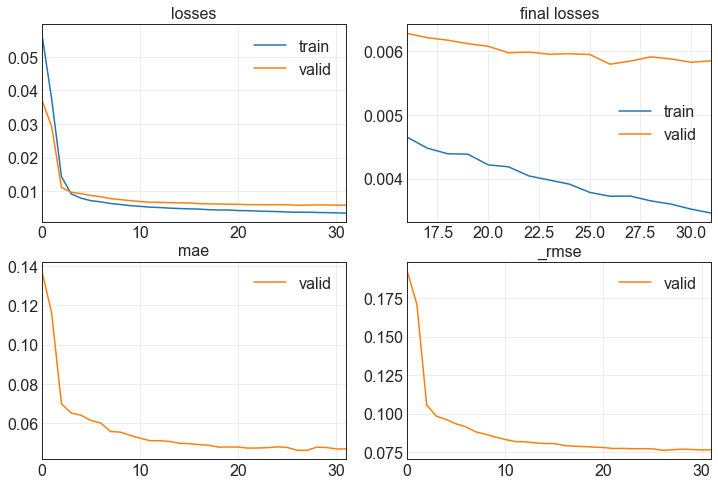

36.81062412261963                                                                                                      
[0.003458623541519046, 0.0058462955057621, 0.04683949425816536, 0.0764610692858696]                                    
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 83%|█████████████████████████████████████▎       | 83/100 [39:23<08:25, 29.75s/trial, best loss: 0.005463892128318548]

No improvement since epoch 40: early stopping                                                                          
 83%|█████████████████████████████████████▎       | 83/100 [39:50<08:25, 29.75s/trial, best loss: 0.005463892128318548]

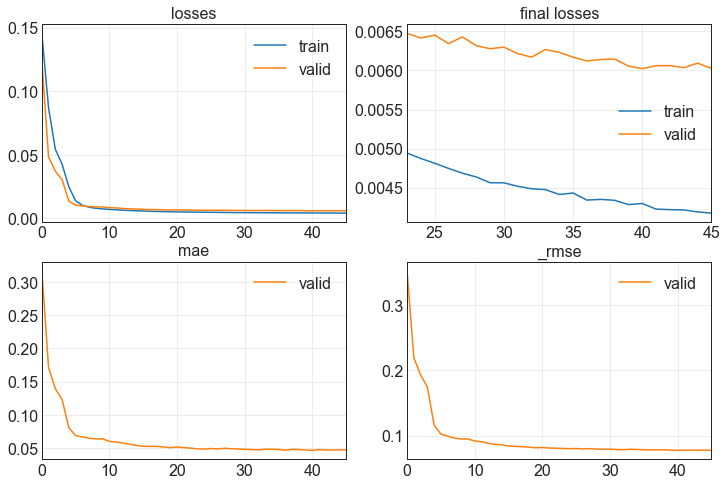

27.15972089767456                                                                                                      
[0.004173255991190672, 0.006027481984347105, 0.04697810113430023, 0.07763686031103134]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 84%|█████████████████████████████████████▊       | 84/100 [39:51<07:48, 29.30s/trial, best loss: 0.005463892128318548]

No improvement since epoch 1: early stopping                                                                           
 84%|█████████████████████████████████████▊       | 84/100 [39:55<07:48, 29.30s/trial, best loss: 0.005463892128318548]

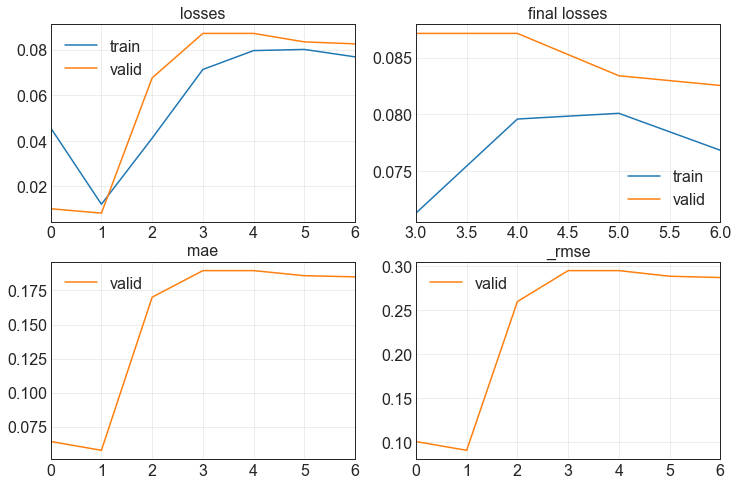

4.62003493309021                                                                                                       
[0.07684978097677231, 0.08255516737699509, 0.18501906096935272, 0.28732413053512573]                                   
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 85%|██████████████████████████████████████▎      | 85/100 [39:57<05:33, 22.23s/trial, best loss: 0.005463892128318548]

No improvement since epoch 38: early stopping                                                                          
 85%|██████████████████████████████████████▎      | 85/100 [41:30<05:33, 22.23s/trial, best loss: 0.005463892128318548]

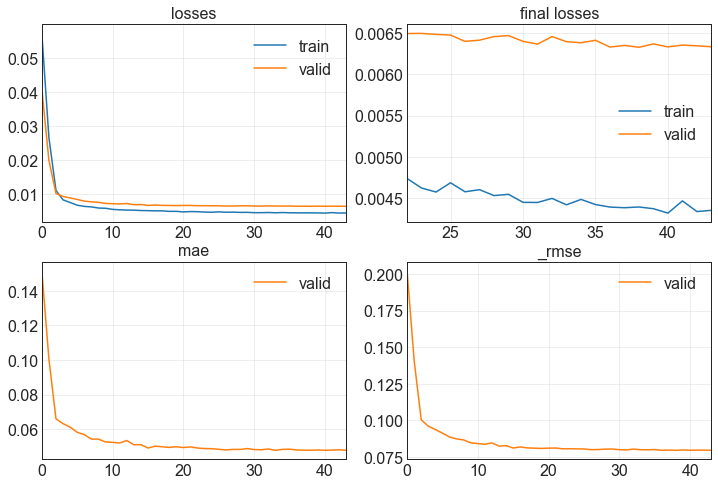

94.06121397018433                                                                                                      
[0.0043520075269043446, 0.006333319935947657, 0.047784965485334396, 0.07958215475082397]                               
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 86%|██████████████████████████████████████▋      | 86/100 [41:32<10:17, 44.10s/trial, best loss: 0.005463892128318548]

No improvement since epoch 87: early stopping                                                                          
 86%|██████████████████████████████████████▋      | 86/100 [42:31<10:17, 44.10s/trial, best loss: 0.005463892128318548]

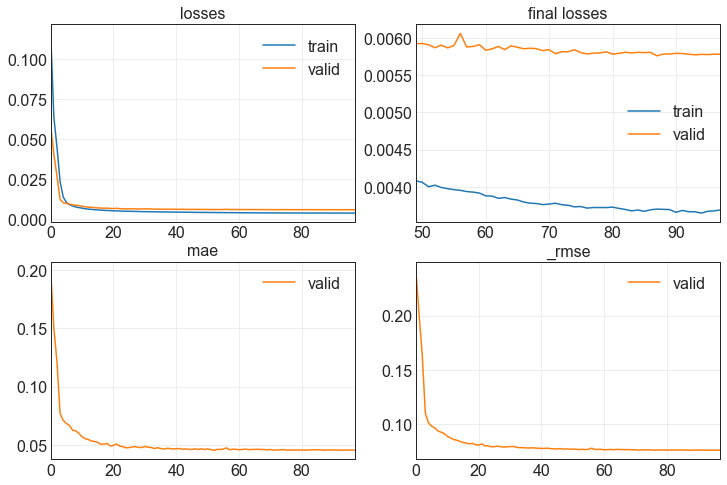

59.247536182403564                                                                                                     
[0.0036906034220010042, 0.005779633764177561, 0.045565903186798096, 0.0760238990187645]                                
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 87%|███████████████████████████████████████▏     | 87/100 [42:32<10:36, 48.98s/trial, best loss: 0.005463892128318548]

No improvement since epoch 7: early stopping                                                                           
 87%|███████████████████████████████████████▏     | 87/100 [42:47<10:36, 48.98s/trial, best loss: 0.005463892128318548]

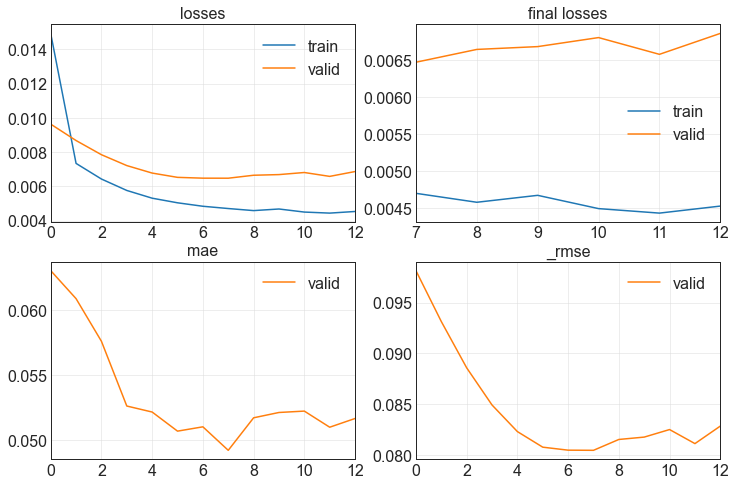

15.280286312103271                                                                                                     
[0.004527117591351271, 0.006861167959868908, 0.051661886274814606, 0.08283216506242752]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 88%|███████████████████████████████████████▌     | 88/100 [42:49<07:50, 39.20s/trial, best loss: 0.005463892128318548]

No improvement since epoch 64: early stopping                                                                          
 88%|███████████████████████████████████████▌     | 88/100 [43:31<07:50, 39.20s/trial, best loss: 0.005463892128318548]

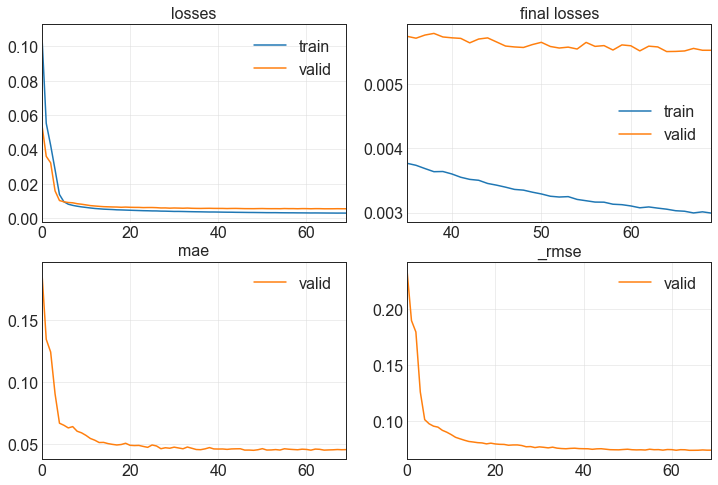

42.29970908164978                                                                                                      
[0.0029910067096352577, 0.0055242860689759254, 0.04554590582847595, 0.07432553917169571]                               
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (200, 200, 200), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 89%|████████████████████████████████████████     | 89/100 [43:32<07:25, 40.46s/trial, best loss: 0.005463892128318548]

No improvement since epoch 7: early stopping                                                                           
 89%|████████████████████████████████████████     | 89/100 [43:36<07:25, 40.46s/trial, best loss: 0.005463892128318548]

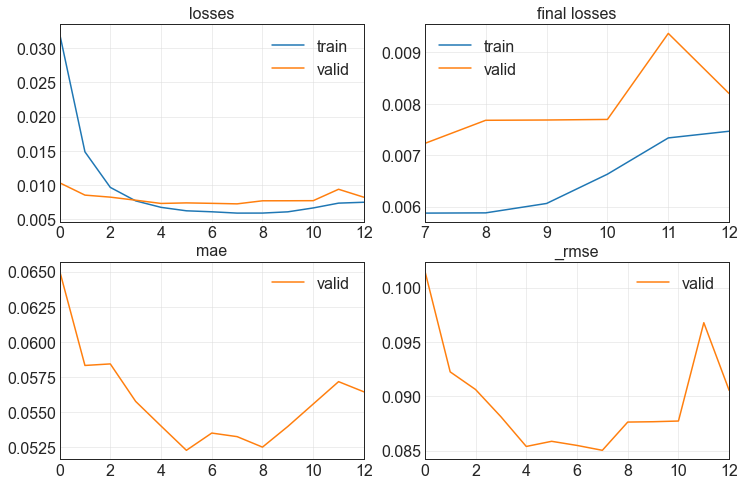

4.72821569442749                                                                                                       
[0.00746558140963316, 0.008197201415896416, 0.0564483143389225, 0.0905383974313736]                                    
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 50, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 90%|████████████████████████████████████████▌    | 90/100 [43:38<05:00, 30.07s/trial, best loss: 0.005463892128318548]

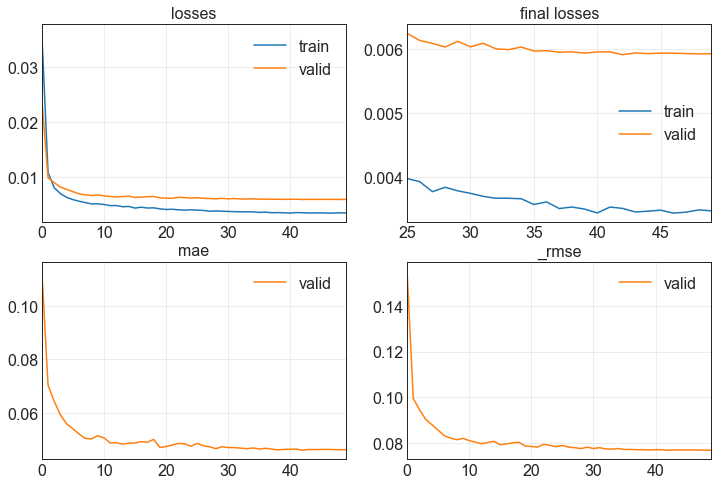

108.09121966362                                                                                                        
[0.003475187812000513, 0.005927874241024256, 0.04624514654278755, 0.07699268311262131]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 91%|████████████████████████████████████████▉    | 91/100 [45:27<08:04, 53.81s/trial, best loss: 0.005463892128318548]

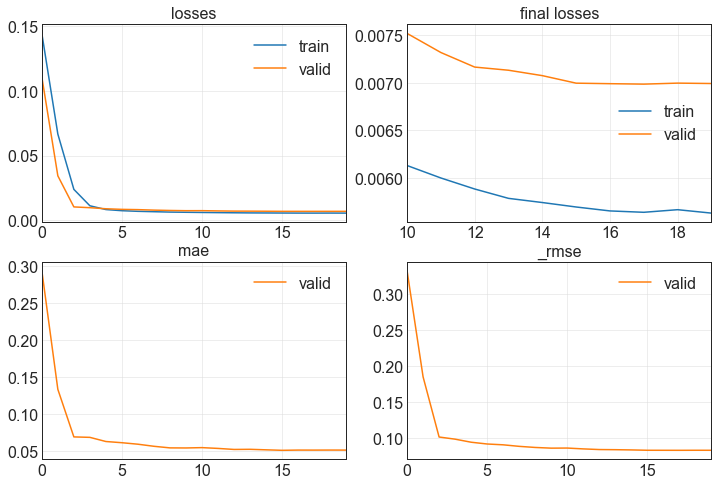

11.855751514434814                                                                                                     
[0.005628879647701979, 0.006992069073021412, 0.05160841345787048, 0.08361860364675522]                                 
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 92%|█████████████████████████████████████████▍   | 92/100 [45:40<05:32, 41.56s/trial, best loss: 0.005463892128318548]

No improvement since epoch 16: early stopping                                                                          
 92%|█████████████████████████████████████████▍   | 92/100 [45:53<05:32, 41.56s/trial, best loss: 0.005463892128318548]

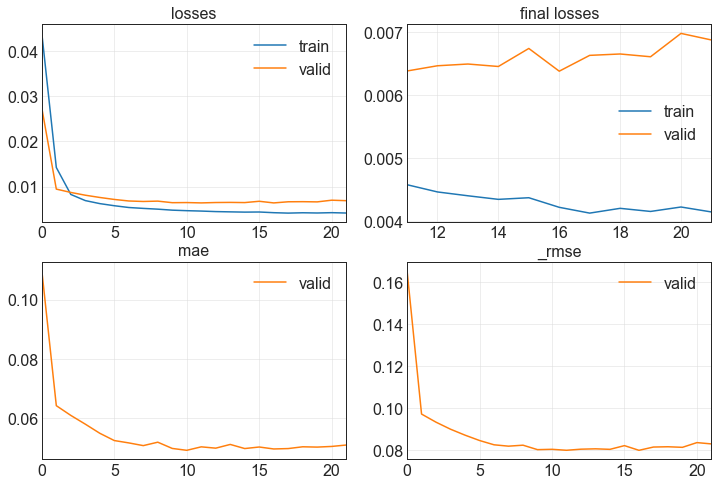

13.499207735061646                                                                                                     
[0.004140190314501524, 0.006870803888887167, 0.051021989434957504, 0.08289030939340591]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 93%|█████████████████████████████████████████▊   | 93/100 [45:55<03:54, 33.48s/trial, best loss: 0.005463892128318548]

No improvement since epoch 45: early stopping                                                                          
 93%|█████████████████████████████████████████▊   | 93/100 [46:25<03:54, 33.48s/trial, best loss: 0.005463892128318548]

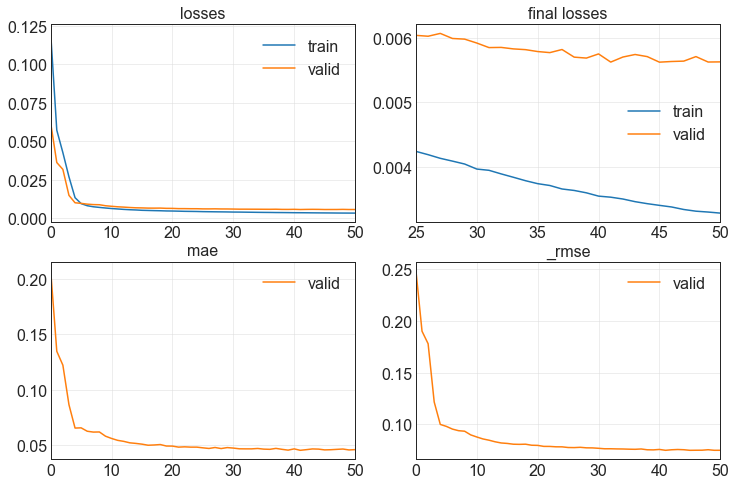

30.940457105636597                                                                                                     
[0.003287349361926317, 0.00562639907002449, 0.04594529792666435, 0.07500933110713959]                                  
Trying params:                                                                                                         
{'batch_size': 32, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (200, 200, 200), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 94%|██████████████████████████████████████████▎  | 94/100 [46:27<03:18, 33.05s/trial, best loss: 0.005463892128318548]

No improvement since epoch 40: early stopping                                                                          
 94%|██████████████████████████████████████████▎  | 94/100 [47:17<03:18, 33.05s/trial, best loss: 0.005463892128318548]

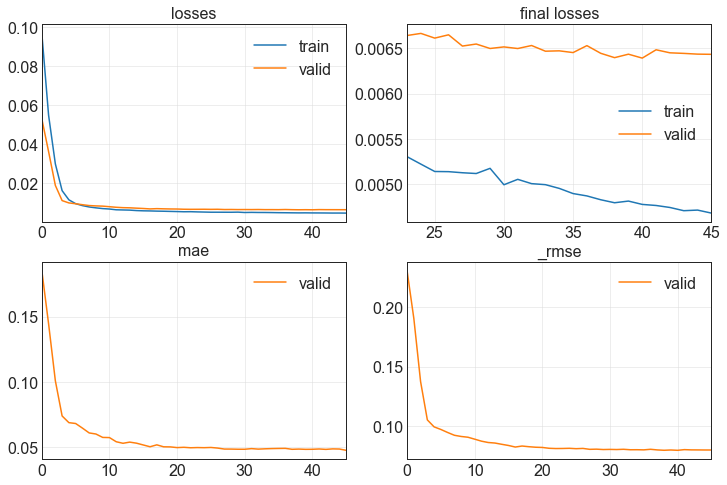

50.28826069831848                                                                                                      
[0.004684228915721178, 0.006433445960283279, 0.04731966182589531, 0.08020877093076706]                                 
Trying params:                                                                                                         
{'batch_size': 128, 'epochs': 50, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.1, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 10}
MLP                                                                                                                    
 95%|██████████████████████████████████████████▊  | 95/100 [47:18<03:12, 38.55s/trial, best loss: 0.005463892128318548]

No improvement since epoch 3: early stopping                                                                           
 95%|██████████████████████████████████████████▊  | 95/100 [47:23<03:12, 38.55s/trial, best loss: 0.005463892128318548]

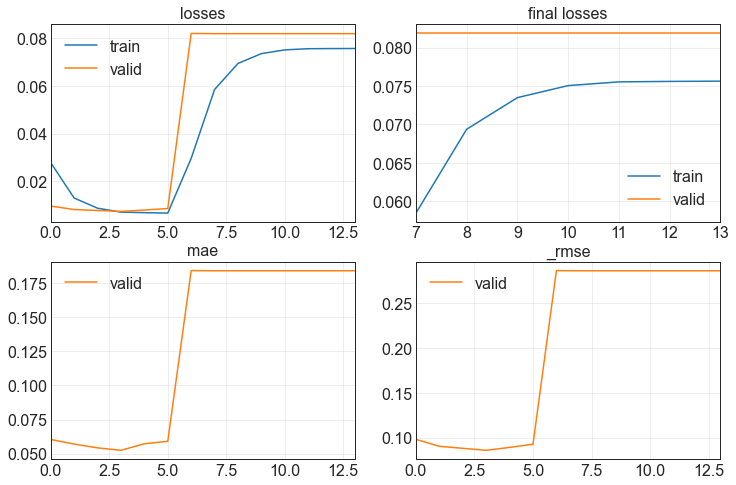

5.070117473602295                                                                                                      
[0.07563889771699905, 0.08185441792011261, 0.18431831896305084, 0.2861020863056183]                                    
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 20, 'fc_dropout': 0.1, 'layers': (100, 100, 100), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 96%|███████████████████████████████████████████▏ | 96/100 [47:24<01:55, 28.84s/trial, best loss: 0.005463892128318548]

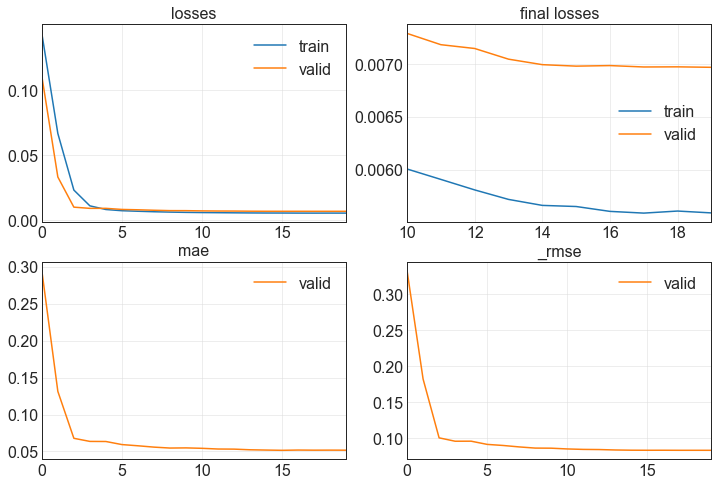

11.973254680633545                                                                                                     
[0.005591399036347866, 0.006966406013816595, 0.05176813527941704, 0.08346500247716904]                                 
Trying params:                                                                                                         
{'batch_size': 16, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 97%|███████████████████████████████████████████▋ | 97/100 [47:37<01:12, 24.11s/trial, best loss: 0.005463892128318548]

No improvement since epoch 22: early stopping                                                                          
 97%|███████████████████████████████████████████▋ | 97/100 [48:38<01:12, 24.11s/trial, best loss: 0.005463892128318548]

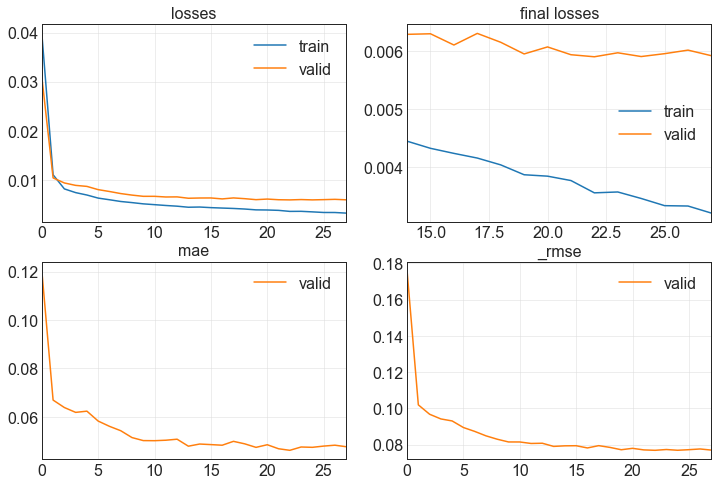

60.700204372406006                                                                                                     
[0.0032063971739262342, 0.005916483234614134, 0.04765940457582474, 0.07691867649555206]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.01, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 98%|████████████████████████████████████████████ | 98/100 [48:39<01:10, 35.42s/trial, best loss: 0.005463892128318548]

No improvement since epoch 15: early stopping                                                                          
 98%|████████████████████████████████████████████ | 98/100 [48:52<01:10, 35.42s/trial, best loss: 0.005463892128318548]

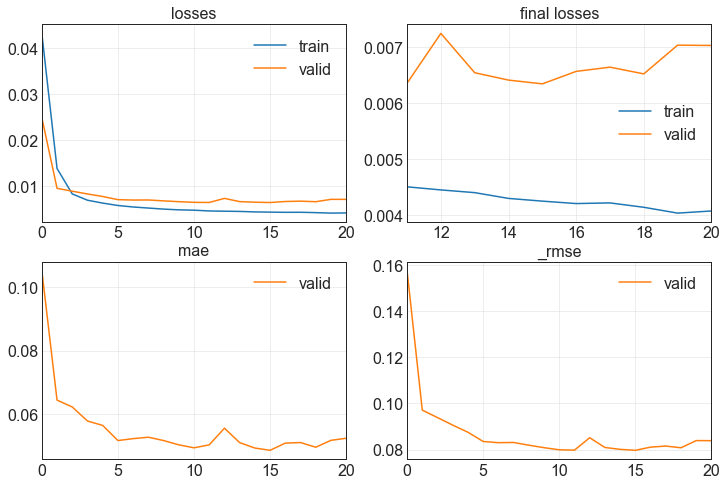

12.90619707107544                                                                                                      
[0.004077460616827011, 0.007030585315078497, 0.052306707948446274, 0.08384858816862106]                                
Trying params:                                                                                                         
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.5, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}
MLP                                                                                                                    
 99%|████████████████████████████████████████████▌| 99/100 [48:53<00:29, 29.00s/trial, best loss: 0.005463892128318548]

No improvement since epoch 51: early stopping                                                                          
 99%|████████████████████████████████████████████▌| 99/100 [49:27<00:29, 29.00s/trial, best loss: 0.005463892128318548]

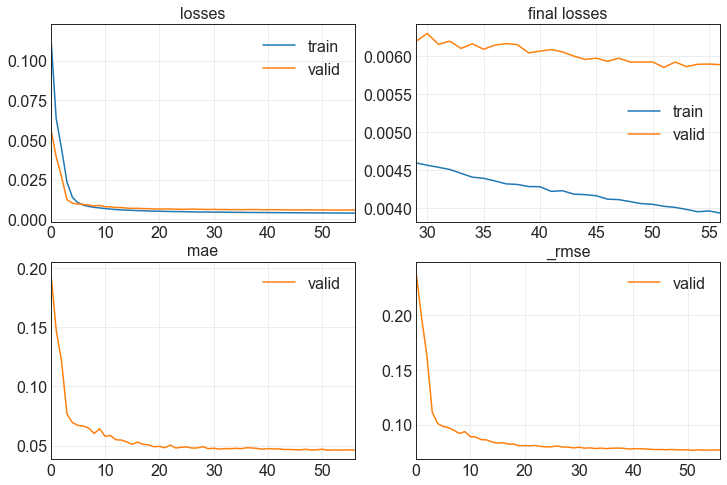

34.62959265708923                                                                                                      
[0.003931151703000069, 0.005890012718737125, 0.046156153082847595, 0.07674641907215118]                                
100%|████████████████████████████████████████████| 100/100 [49:28<00:00, 29.68s/trial, best loss: 0.005463892128318548]


In [57]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=max_evals,  # test trials
    trials=trials)

In [58]:
print("Best parameters:")
print(space_eval(search_space, best))
params = space_eval(search_space, best)

Best parameters:
{'batch_size': 64, 'epochs': 100, 'fc_dropout': 0.1, 'layers': (500, 500, 500), 'lr': 0.001, 'optimizer': <function Adam at 0x000001F31EC94438>, 'patience': 5}


In [59]:
# only for debug
# params = {'batch_size': 16, 'bidirectional': False, 'epochs': 20, 'hidden_size': 200, 'lr': 0.01, 'n_layers': 5, 'optimizer': Adam, 'patience': 10}

# Retrain the model with best hyperparameter

We use training data for training and validation data for (possible) early stopping:

In [60]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [61]:
X.shape

(7990, 196, 10)

In [62]:
y.shape

(7990, 196)

In [63]:
batch_size = params["batch_size"]

In [64]:
tfms  = [None, [TSRegression()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
# set num_workers for memory bottleneck
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)

Create the model:

In [65]:
arch = MLP
k = {
    'layers': params['layers'],
    'fc_dropout': params['fc_dropout']
}
model = create_model(arch, dls=dls, **k)
print(model.__class__.__name__)

MLP


In [66]:
# Add a Sigmoid layer
model = nn.Sequential(model, nn.Sigmoid())

In [67]:
model

Sequential(
  (0): MLP(
    (flatten): Reshape(bs, -1)
    (mlp): ModuleList(
      (0): LinBnDrop(
        (0): Dropout(p=0.1, inplace=False)
        (1): Linear(in_features=1960, out_features=500, bias=True)
        (2): ReLU(inplace=True)
      )
      (1): LinBnDrop(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=500, out_features=500, bias=True)
        (2): ReLU(inplace=True)
      )
      (2): LinBnDrop(
        (0): Dropout(p=0.2, inplace=False)
        (1): Linear(in_features=500, out_features=500, bias=True)
        (2): ReLU(inplace=True)
      )
    )
    (head): Sequential(
      (0): LinBnDrop(
        (0): Dropout(p=0.1, inplace=False)
        (1): Linear(in_features=500, out_features=196, bias=True)
      )
    )
  )
  (1): Sigmoid()
)

In [68]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

1,579,696 total parameters.
1,579,696 training parameters.


Training the model:

No improvement since epoch 49: early stopping


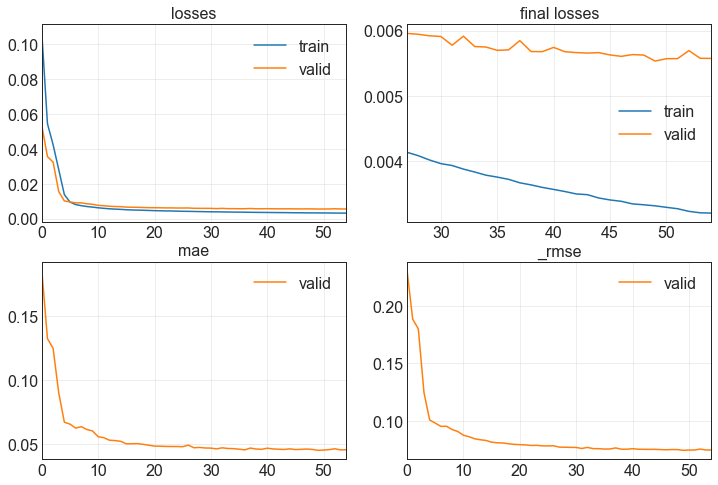

In [69]:
learn = Learner(dls, model, metrics=[mae, rmse], opt_func=params['optimizer'])
start = time.time()
learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                    cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
training_time = time.time() - start
learn.plot_metrics()

Evaluate the model:

In [70]:
dls = learn.dls
valid_dl = dls.valid

In [71]:
test_ds = valid_dl.dataset.add_test(X_test, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

1999


In [72]:
start = time.time()
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
prediction_time = time.time() - start
test_probas, test_targets, test_preds

(tensor([[0.6862, 0.1453, 0.6925,  ..., 0.5273, 0.0017, 0.0018],
         [0.6845, 0.1442, 0.6929,  ..., 0.5220, 0.0017, 0.0018],
         [0.6929, 0.1485, 0.6982,  ..., 0.5180, 0.0019, 0.0020],
         ...,
         [0.7600, 0.1512, 0.7279,  ..., 0.6097, 0.0030, 0.0026],
         [0.7669, 0.1530, 0.7289,  ..., 0.6091, 0.0029, 0.0026],
         [0.7711, 0.1585, 0.7284,  ..., 0.6014, 0.0033, 0.0030]]),
 tensor([[0.7516, 0.2175, 0.7770,  ..., 0.5197, 0.0000, 0.0000],
         [0.7553, 0.2080, 0.7623,  ..., 0.5126, 0.0000, 0.0000],
         [0.7457, 0.1962, 0.7510,  ..., 0.4877, 0.0000, 0.0000],
         ...,
         [0.7723, 0.1825, 0.6382,  ..., 0.6950, 0.0000, 0.0000],
         [0.7608, 0.1724, 0.6434,  ..., 0.6812, 0.0000, 0.0000],
         [0.7262, 0.1734, 0.6523,  ..., 0.6877, 0.0000, 0.0000]]),
 tensor([[0.6862, 0.1453, 0.6925,  ..., 0.5273, 0.0017, 0.0018],
         [0.6845, 0.1442, 0.6929,  ..., 0.5220, 0.0017, 0.0018],
         [0.6929, 0.1485, 0.6982,  ..., 0.5180, 0.0019, 0.

In [73]:
test_targets.shape

torch.Size([1999, 196])

In [74]:
test_preds.shape

torch.Size([1999, 196])

In [75]:
y_true = test_targets.numpy()
y_pred = test_preds.numpy()

Reshape the data into multiple steps

In [76]:
y_true = y_true.reshape(y_true.shape[0], horizon, -1)
y_pred = y_pred.reshape(y_pred.shape[0], horizon, -1)

In [77]:
y_true.shape

(1999, 1, 196)

In [78]:
y_pred.shape

(1999, 1, 196)

Transform the data in the normal range:

In [79]:
def inverse_normalization(prediction, y, max_list, min_list):
    inverse_prediction = prediction * (max_list - min_list) + min_list
    inverse_y = y * (max_list - min_list) + min_list

    return inverse_prediction, inverse_y

In [80]:
y_true_list = []
y_pred_list = []
for i in range(y_true.shape[0]):
    y_true_tmp = []
    y_pred_tmp = []
    for step in range(y_true.shape[1]):
        inverse_prediction, inverse_y = inverse_normalization(y_pred[i, step, :], y_true[i, step, :], max_list, min_list)
        
        y_true_tmp.append(inverse_y)
        y_pred_tmp.append(inverse_prediction)
    y_true_list.append(y_true_tmp)
    y_pred_list.append(y_pred_tmp)

In [81]:
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

In [82]:
y_true.shape

(1999, 1, 196)

In [83]:
y_pred.shape

(1999, 1, 196)

# Save Predictions and Evaluate Model

Save true values and predictions first:

In [84]:
pickle.dump(y_pred, open(y_pred_fn, 'wb'))

In [85]:
pickle.dump(y_true, open(y_true_fn, 'wb'))

The training and test time spent:

In [86]:
print('Training time (in seconds): ', training_time)
print('Test time (in seconds): ', prediction_time)

Training time (in seconds):  32.82909083366394
Test time (in seconds):  0.1419992446899414


In [92]:
print('Training time (in seconds) per epoch: ', 32.82909083366394 / 55)

Training time (in seconds) per epoch:  0.5968925606120716


Calculate the RMSE and MAE for differnt time steps:

In [88]:
for step in range(horizon):
    print('Prediction for the next %d frame' % (step + 1))
    print('RMSE: ', math.sqrt(mean_squared_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten())) / 1000)  # in Mbps
    print('MAE: ', mean_absolute_error(y_true[:, step, :].flatten(), y_pred[:, step, :].flatten()) / 1000 )

Prediction for the next 1 frame
RMSE:  55.55351029395543
MAE:  18.611997597231884


Plot the RMSE and MAE distributions for each time step:

In [89]:
def plot_RMSE(y_true, y_pred, fn, xlim=60):
    RMSE_list = []

    for i in range(y_true.shape[0]):
        rmse = math.sqrt(mean_squared_error(y_true[i].flatten(), y_pred[i].flatten())) / 1000
        RMSE_list.append(rmse)
    
    data = RMSE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("RMSE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

In [90]:
def plot_MAE(y_true, y_pred, fn, xlim=60):
    MAE_list = []

    for i in range(y_true.shape[0]):
        mae = mean_absolute_error(y_true[i].flatten(), y_pred[i].flatten()) / 1000
        MAE_list.append(mae)
    
    data = MAE_list
    data_size = len(data)
    data_set = sorted(set(data))
    bins = np.append(data_set, data_set[-1] + 1)

    # Use the histogram function to bin the data
    counts, bin_edges = np.histogram(data, bins=bins, density=False)
    counts = counts.astype(float) / data_size
    
    plt.figure(figsize=[12, 9])
    plt.xlabel("MAE (Mbps)")
    plt.xlim((0, xlim))
    plt.ylabel("CDF")
    plt.ylim((0, 1))

    # Format the x tick labels
    ax = plt.gca()
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.xaxis.set_major_formatter(formatter)

    cdf = np.cumsum(counts)
    plt.plot(bin_edges[0:-1], cdf)
    
    plt.savefig(fn, bbox_inches = 'tight', pad_inches = 0.1)

MLP_TM-minmax_RMSE-10-1-step-1.pdf
MLP_TM-minmax_MAE-10-1-step-1.pdf


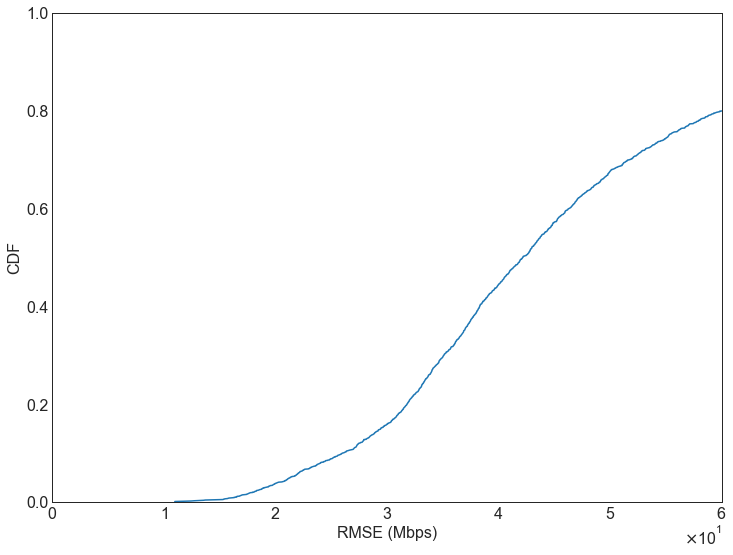

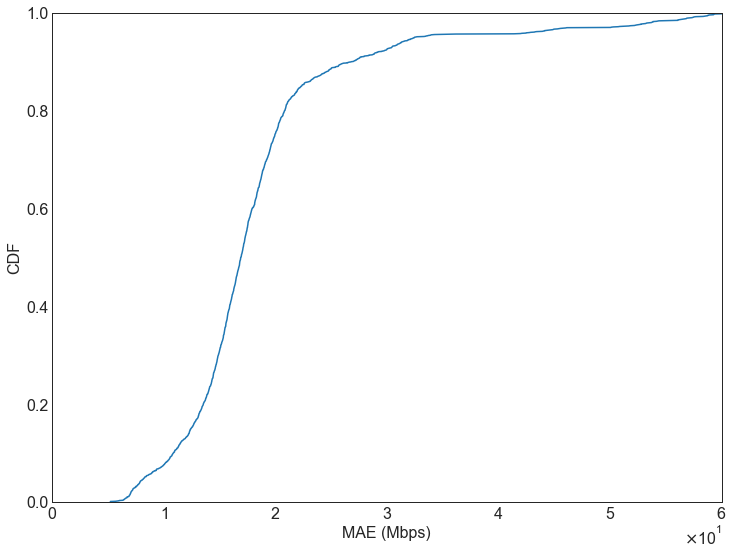

In [91]:
for step in range(horizon):
    fn = RMSE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_RMSE(y_true[:, step, :], y_pred[:, step, :], fn)
    
    fn = MAE_fn % (history, horizon, step + 1)
    print(fn)
    
    plot_MAE(y_true[:, step, :], y_pred[:, step, :], fn)